A notebook where we synthesize regression models when we observe data from systems under the same condition.  What we are interested in here is fitting models when we observe only a little bit of data from each system - so that we should do better when we fit models together then seperately. 

Specifically, we synthesize regression models that predict only one variable.  The models project data down to a single variable, which is then passed through a complicated non-linear function.  

Some details:

1) Each input variable in the model is associated with a 2-d position (position is the measurable property in this example).  Variable positions are sampled uniformly from the unit square. 

2) We pull the weights for each model from a prior where the mean and std. conditioned on position are sums of bump functions (so they are truly smooth). When fitting models, we use hypercube functions for the mean and std. (so there
is model mismatch here).  This can make correctly learning the std functions tricky, because if the true mean functions vary alot within a single hypercube, we will learn a standard deviation that is elevated in that region

3) We simulate data with scales and biases which are very close to 1 and 0, respectively.  This keeps things simpler.  When fitting, we use priors which assume scales and biases are concentrated near these values. 

4) We pull noise variances from a Gamma distribution when simulating data, and we also fit models with priors and posteriors which are also Gamma distributions over noise variances.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices

from probabilistic_model_synthesis.gaussian_nonlinear_regression import compare_weight_prior_dists
from probabilistic_model_synthesis.gaussian_nonlinear_regression import align_low_d_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_regression import fit_with_hypercube_priors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.simulation import generate_sum_of_bump_fcns_dist
from probabilistic_model_synthesis.simulation import sample_proj_data_from_interval
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts

In [3]:
%matplotlib notebook
plt.style.use('dark_background')

## Parameters go here

In [4]:
# Range of the number of input variables we observe from each individual - the actual number of variables we 
# observe from an individual will be pulled uniformly from this range (inclusive)
n_input_var_range = [5000, 5100]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [1000, 2000]

# Specify the number of inidividuals we observe data from
n_individuals = 80

# ===============================================================================================
# Parameters for the true priors 

# Options for the prior distribution on weights
true_w_prior_opts = {'n_bump_fcns': 50, 'd_in': 2, 'p': 1, 'mn_m_std': 1.0, 'std_m_std': .1, 'bump_w': .2}

# Options for the prior distributions on the scales, biases and psi
true_s_in_prior_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_s_out_prior_opts = {'mn_mn': 1.0, 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_b_prior_opts = {'mn_mn': 0.0, 'mn_std': .00000001, 'std_iv': .001}
true_psi_prior_opts = {'conc_iv': 10.0, 'rate_iv': 1000.0, 'rate_ub': 10000.0}

# ===============================================================================================
# Parameters for the fit models

# The full options for setting up the prior on weights
fit_hc_params = {'n_divisions_per_dim': [20, 20], 
                 'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                 'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
fit_w_prior_opts = {'mn_hc_params': fit_hc_params, 'std_hc_params': fit_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
fit_s_in_prior_opts = true_s_in_prior_opts
fit_s_out_prior_opts = true_s_out_prior_opts
fit_b_prior_opts = true_b_prior_opts
fit_psi_prior_opts = true_psi_prior_opts

# Options for posterior distribtions 
s_in_post_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}
s_out_post_opts = {'mn_mn': 1.0, 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}

b_post_opts = {'mn_mn': 0.0, 'mn_std': .01}
psi_post_opts = {'conc_iv': 10.0, 'rate_iv': 1.0, 'rate_ub': 100000.0}

# Options for the densenet which makes up the shared-m module
dense_net_opts = {'n_layers': 10, 'growth_rate': 5, 'bias': True}

# ======================================================================================================
# Parameters for fitting - should be entered as lists, each entry corresponding to one round of fitting

# Parameters when fitting combined models
comb_sp_fit_opts = [{'n_epochs': 100, 'milestones': None, 'update_int': 100, 'init_lr': .1}]
comb_ip_fit_opts = [{'n_epochs': 5000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]

single_sp_fit_opts = [{'n_epochs': 100, 'milestones': None, 'update_int': 100, 'init_lr': .1}]
single_ip_fit_opts = [{'n_epochs': 5000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]


# ======================================================================================================
# Specify the number of intermediate variables and number of variables we predict
p = 1
d_pred = 1


## Create true distributions that govern how systems under study are generated

In [5]:
# Because we do not use the hypercube priors on weights, we provide some default paramaters for these before
# creating the priors

temp_hc_params = {'n_divisions_per_dim': [10, 10], 
                  'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                   'n_div_per_hc_side_per_dim': [1, 1]}

temp_w_prior_opts = {'mn_hc_params': temp_hc_params, 'std_hc_params': temp_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

true_priors = generate_hypercube_prior_collection(p=p, d_pred=d_pred, 
                                                  w_prior_opts=temp_w_prior_opts, 
                                                  s_in_prior_opts=true_s_in_prior_opts, 
                                                  b_in_prior_opts=true_b_prior_opts, 
                                                  s_out_prior_opts=true_s_out_prior_opts,
                                                  b_out_prior_opts=true_b_prior_opts, 
                                                  psi_prior_opts=true_psi_prior_opts)

# We replace the prior over weights 
true_priors.w_prior = generate_sum_of_bump_fcns_dist(**true_w_prior_opts)

## Define the true non-linear function relating projections of input variables to the mean of output variables

In [6]:
class Quad(torch.nn.Module):
    
    def forward(self, x):
        return x + torch.sin(3*x) 

In [7]:
m_true = Quad()

## Generate data

### Generate properties

In [8]:
ind_n_vars = np.random.randint(n_input_var_range[0], n_input_var_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

### Generate true models for each individual

In [9]:
with torch.no_grad():
    ind_true_mdls = [GNLRMdl(m=m_true, 
                     w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(props)),
                     s_in=true_priors.s_in_prior.form_standard_sample(true_priors.s_in_prior.sample(props)).squeeze(axis=1),
                     b_in=true_priors.b_in_prior.form_standard_sample(true_priors.b_in_prior.sample(props)).squeeze(axis=1),
                     s_out=true_priors.s_out_prior.form_standard_sample(true_priors.s_out_prior.sample(props)).squeeze(axis=1),
                     b_out=true_priors.b_out_prior.form_standard_sample(true_priors.b_out_prior.sample(props)).squeeze(axis=1),
                     psi=true_priors.psi_prior.form_standard_sample(true_priors.psi_prior.sample(props)).squeeze(axis=1))
                     for props in ind_props]
    
    if d_pred > 1:
        for mdl in ind_true_mdls:
            mdl.s_out.data = mdl.s_out.data.squeeze()
            mdl.b_out.data = mdl.b_out.data.squeeze()
            mdl.psi.data = mdl.psi.data.squeeze()
                             

### Generate observations from true models

In [10]:
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_data = [None]*n_individuals

interval = 1.96*np.sqrt(n_input_var_range[0])*np.asarray([-1, 1])

for i in range(n_individuals):
    x_i = torch.tensor(sample_proj_data_from_interval(n_smps=ind_n_smps[i], 
                                                      w=ind_true_mdls[i].w.detach().numpy(), 
                                                      interval=interval),
                       dtype=torch.float)
    with torch.no_grad():
        y_i = ind_true_mdls[i].sample(x=x_i)
    ind_data[i] = (x_i, y_i)
    
    print('Done generating data for individual ' + str(i) + '.')
    

Done generating data for individual 0.
Done generating data for individual 1.
Done generating data for individual 2.
Done generating data for individual 3.
Done generating data for individual 4.
Done generating data for individual 5.
Done generating data for individual 6.
Done generating data for individual 7.
Done generating data for individual 8.
Done generating data for individual 9.
Done generating data for individual 10.
Done generating data for individual 11.
Done generating data for individual 12.
Done generating data for individual 13.
Done generating data for individual 14.
Done generating data for individual 15.
Done generating data for individual 16.
Done generating data for individual 17.
Done generating data for individual 18.
Done generating data for individual 19.
Done generating data for individual 20.
Done generating data for individual 21.
Done generating data for individual 22.
Done generating data for individual 23.
Done generating data for individual 24.
Done gener

## Plot sample data 

In [11]:
smp_data_ind = 0

<IPython.core.display.Javascript object>


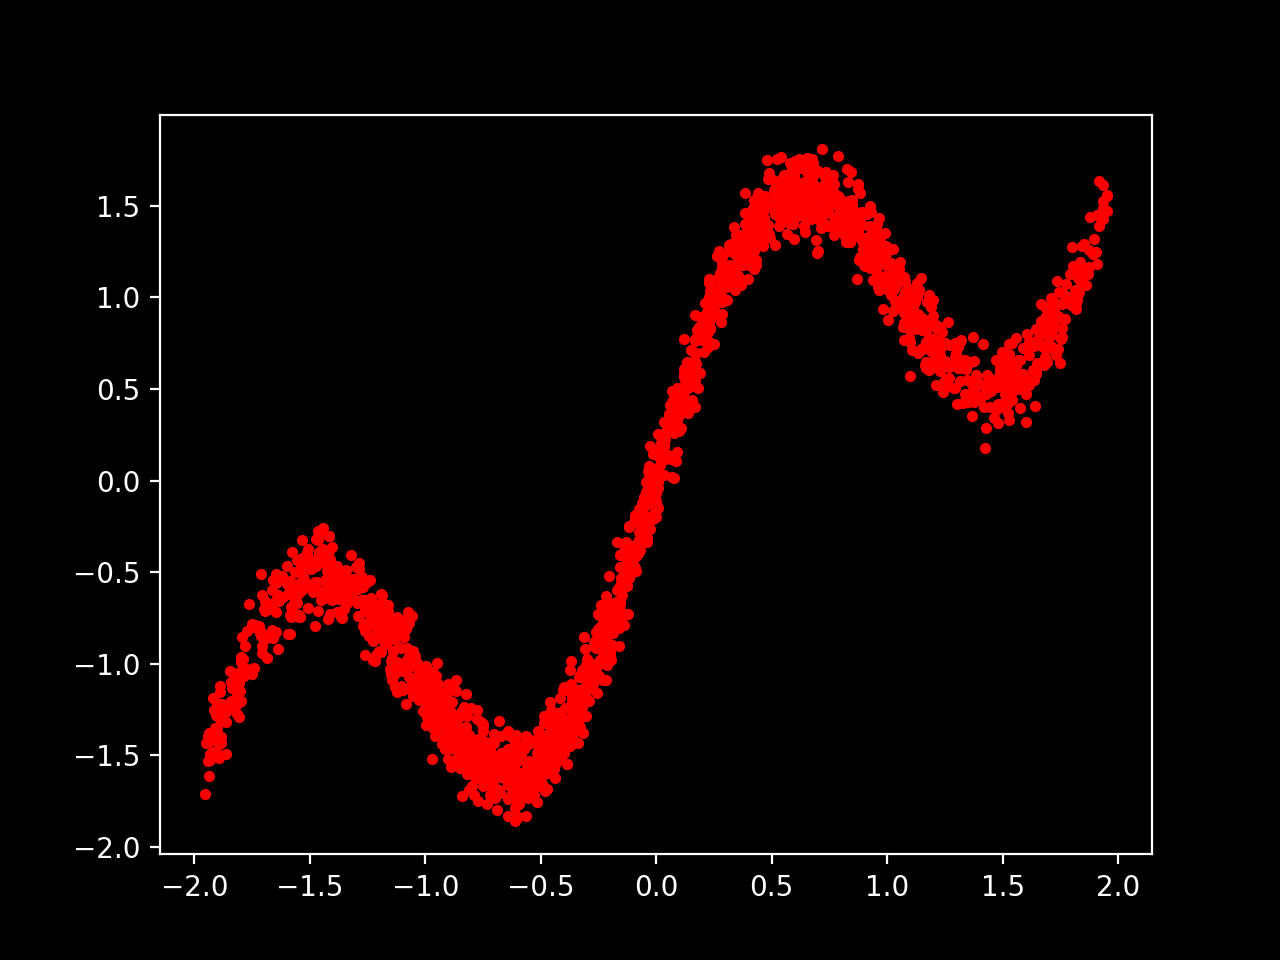

In [12]:
x_proj = ind_true_mdls[smp_data_ind].project(ind_data[smp_data_ind][0]).detach().numpy()
y_mn = ind_true_mdls[smp_data_ind].cond_mean(ind_data[smp_data_ind][0]).detach().numpy()
y_est = ind_data[smp_data_ind][1]
plt.figure()
plt.plot(x_proj, y_est, 'r.')
#pred_mns = ind_data[smp_data_ind][1]

## Synthesize models (fit models to the data together)

In [13]:
comb_fit_rs = fit_with_hypercube_priors(data=ind_data, props=ind_props, p=p, 
                                   w_prior_opts=fit_w_prior_opts, 
                                   s_in_prior_opts=fit_s_in_prior_opts,
                                   b_in_prior_opts=fit_b_prior_opts,
                                   s_out_prior_opts=fit_s_out_prior_opts,
                                   b_out_prior_opts=fit_b_prior_opts,
                                   psi_prior_opts=fit_psi_prior_opts,
                                   s_in_post_opts=s_in_post_opts,
                                   b_in_post_opts=b_post_opts,
                                   s_out_post_opts=s_out_post_opts,
                                   b_out_post_opts=b_post_opts,
                                   psi_post_opts=psi_post_opts,
                                   dense_net_opts=dense_net_opts, 
                                   sp_fit_opts=comb_sp_fit_opts, 
                                   ip_fit_opts=comb_ip_fit_opts)
                        

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 4.05e+09
----------------------------------------
NELL: 4.45e+03, 2.14e+03, 3.39e+03, 4.59e+03, 3.95e+03, 3.13e+03, 3.87e+03, 3.77e+03, 3.23e+03, 3.44e+03, 3.02e+03, 3.43e+03, 3.35e+03, 3.69e+03, 3.83e+03, 4.32e+03, 4.44e+03, 3.84e+03, 3.01e+03, 2.47e+03, 3.50e+03, 3.89e+03, 3.90e+03, 3.93e+03, 4.22e+03, 4.18e+03, 3.99e+03, 3.30e+03, 3.32e+03, 3.24e+03, 4.06e+03, 3.75e+03, 2.50e+03, 4.08e+03, 2.62e+03, 3.45e+03, 2.77e+03, 2.97e+03, 3.01e+03, 3.56e+03, 3.78e+03, 3.87e+03, 3.28e+03, 2.46e+03, 3.55e+03, 2.70e+03, 3.32e+03, 3.36e+03, 2.94e+03, 2.86e+03, 3.48e+03, 4.01e+03, 3.79e+03, 3.70e+03, 3.14e+03, 2.96e+03, 3.94e+03, 3.74e+03, 2.16e+03, 3.11e+03, 4.17e+03, 3.73e+03, 3.33e+03, 2.68e+03, 4.10e+03, 3.45e+03, 4.47e+03, 3.60e+03, 3.90e+03, 3.14e+03, 3.00e+03, 3.80e+03, 4.31e+03, 3.45e+03, 3.81e+03, 2.68e+03, 2.65e+03, 4.31e+03, 3.84e+03, 3.91e+03
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+0


=========== EPOCH 100 COMPLETE ===========
Obj: 1.11e+05
----------------------------------------
NELL: 1.61e+03, 9.17e+02, 1.29e+03, 1.58e+03, 1.24e+03, 1.42e+03, 1.46e+03, 1.41e+03, 1.52e+03, 1.20e+03, 1.02e+03, 1.08e+03, 1.15e+03, 1.20e+03, 1.33e+03, 1.39e+03, 1.68e+03, 1.26e+03, 1.16e+03, 9.77e+02, 1.19e+03, 1.93e+03, 1.57e+03, 1.62e+03, 1.38e+03, 1.45e+03, 2.03e+03, 1.07e+03, 1.31e+03, 1.28e+03, 2.21e+03, 1.26e+03, 1.54e+03, 1.36e+03, 9.63e+02, 1.22e+03, 1.28e+03, 1.17e+03, 1.19e+03, 1.29e+03, 1.47e+03, 1.20e+03, 1.22e+03, 9.62e+02, 1.59e+03, 9.24e+02, 1.57e+03, 1.16e+03, 8.64e+02, 1.20e+03, 1.12e+03, 1.38e+03, 1.35e+03, 1.48e+03, 1.26e+03, 1.05e+03, 1.58e+03, 1.88e+03, 8.63e+02, 1.41e+03, 1.55e+03, 1.43e+03, 1.25e+03, 1.01e+03, 1.51e+03, 1.37e+03, 1.60e+03, 1.60e+03, 1.58e+03, 1.33e+03, 1.23e+03, 1.30e+03, 1.52e+03, 1.42e+03, 1.30e+03, 8.67e+02, 1.36e+03, 1.76e+03, 2.16e+03, 1.65e+03
W KL: 1.60e+01, 9.98e+00, 6.91e+01, 5.43e+01, 6.92e+01, 4.03e+00, 9.43e+01, 3.00e+01, 6.06e+00, 


=========== EPOCH 300 COMPLETE ===========
Obj: 9.62e+04
----------------------------------------
NELL: 1.35e+03, 7.01e+02, 1.05e+03, 1.21e+03, 1.01e+03, 9.45e+02, 1.26e+03, 1.27e+03, 9.38e+02, 1.05e+03, 9.02e+02, 1.10e+03, 9.70e+02, 1.19e+03, 1.14e+03, 1.11e+03, 1.34e+03, 1.21e+03, 8.38e+02, 7.72e+02, 1.14e+03, 1.48e+03, 1.05e+03, 1.13e+03, 1.15e+03, 1.41e+03, 1.28e+03, 9.58e+02, 1.16e+03, 1.01e+03, 1.36e+03, 1.05e+03, 9.00e+02, 1.33e+03, 9.01e+02, 1.04e+03, 7.13e+02, 1.09e+03, 9.45e+02, 1.09e+03, 9.75e+02, 1.08e+03, 9.12e+02, 7.14e+02, 1.13e+03, 8.33e+02, 1.11e+03, 1.16e+03, 8.55e+02, 8.68e+02, 9.25e+02, 9.79e+02, 1.14e+03, 1.10e+03, 9.45e+02, 8.40e+02, 1.13e+03, 1.32e+03, 7.60e+02, 1.18e+03, 1.29e+03, 1.27e+03, 9.93e+02, 9.31e+02, 1.10e+03, 8.77e+02, 1.40e+03, 1.05e+03, 1.22e+03, 1.02e+03, 9.63e+02, 1.10e+03, 1.33e+03, 9.57e+02, 1.16e+03, 7.84e+02, 8.43e+02, 1.32e+03, 1.51e+03, 1.18e+03
W KL: 1.75e+02, 9.56e+01, 1.95e+02, 1.88e+02, 1.81e+02, 9.72e+01, 9.80e+01, 1.20e+02, 1.12e+02, 


=========== EPOCH 500 COMPLETE ===========
Obj: 9.49e+04
----------------------------------------
NELL: 1.20e+03, 6.63e+02, 8.73e+02, 1.12e+03, 9.01e+02, 8.75e+02, 1.08e+03, 1.07e+03, 9.80e+02, 9.19e+02, 8.36e+02, 9.05e+02, 9.39e+02, 1.16e+03, 1.08e+03, 1.08e+03, 1.13e+03, 9.46e+02, 7.46e+02, 6.93e+02, 9.40e+02, 9.83e+02, 1.03e+03, 8.96e+02, 1.03e+03, 1.31e+03, 1.09e+03, 9.07e+02, 9.12e+02, 9.42e+02, 1.19e+03, 9.93e+02, 7.51e+02, 1.06e+03, 8.34e+02, 9.01e+02, 5.97e+02, 9.05e+02, 8.29e+02, 8.56e+02, 9.17e+02, 1.02e+03, 8.35e+02, 6.74e+02, 1.00e+03, 6.90e+02, 1.17e+03, 9.07e+02, 7.69e+02, 7.89e+02, 7.73e+02, 8.48e+02, 9.45e+02, 1.07e+03, 8.38e+02, 6.94e+02, 1.05e+03, 1.06e+03, 6.13e+02, 9.15e+02, 1.07e+03, 1.07e+03, 8.67e+02, 8.10e+02, 9.96e+02, 8.48e+02, 1.28e+03, 9.86e+02, 1.31e+03, 8.59e+02, 9.23e+02, 1.09e+03, 1.18e+03, 9.21e+02, 9.29e+02, 7.08e+02, 8.23e+02, 1.05e+03, 1.12e+03, 1.08e+03
W KL: 2.87e+02, 1.65e+02, 1.89e+02, 2.97e+02, 3.24e+02, 2.63e+02, 2.33e+02, 2.02e+02, 1.78e+02, 


=========== EPOCH 700 COMPLETE ===========
Obj: 8.52e+04
----------------------------------------
NELL: 1.16e+03, 6.44e+02, 8.91e+02, 1.10e+03, 8.90e+02, 7.99e+02, 1.10e+03, 8.72e+02, 7.93e+02, 8.99e+02, 8.11e+02, 8.28e+02, 8.82e+02, 9.49e+02, 1.04e+03, 1.03e+03, 1.17e+03, 1.03e+03, 7.30e+02, 1.04e+03, 9.28e+02, 1.07e+03, 9.14e+02, 9.30e+02, 9.28e+02, 1.20e+03, 1.08e+03, 8.19e+02, 9.32e+02, 8.28e+02, 1.21e+03, 8.73e+02, 8.50e+02, 1.04e+03, 7.52e+02, 7.79e+02, 5.95e+02, 1.02e+03, 7.70e+02, 7.74e+02, 9.06e+02, 1.07e+03, 8.09e+02, 7.08e+02, 9.70e+02, 6.53e+02, 8.40e+02, 8.71e+02, 7.13e+02, 7.68e+02, 7.64e+02, 8.98e+02, 9.26e+02, 9.63e+02, 7.73e+02, 7.78e+02, 1.10e+03, 1.02e+03, 5.56e+02, 9.85e+02, 1.06e+03, 1.02e+03, 8.31e+02, 7.21e+02, 1.14e+03, 8.11e+02, 1.08e+03, 9.78e+02, 9.53e+02, 8.88e+02, 8.87e+02, 9.87e+02, 1.09e+03, 8.37e+02, 9.43e+02, 6.37e+02, 7.16e+02, 1.15e+03, 1.21e+03, 9.70e+02
W KL: 2.02e+02, 8.74e+01, 1.36e+02, 2.00e+02, 1.60e+02, 1.25e+02, 1.70e+02, 1.96e+02, 1.41e+02, 


=========== EPOCH 900 COMPLETE ===========
Obj: 8.45e+04
----------------------------------------
NELL: 1.11e+03, 6.60e+02, 8.41e+02, 1.00e+03, 8.98e+02, 7.68e+02, 1.06e+03, 8.67e+02, 7.97e+02, 9.51e+02, 7.69e+02, 8.84e+02, 8.00e+02, 9.24e+02, 9.98e+02, 1.05e+03, 1.16e+03, 9.81e+02, 6.93e+02, 5.78e+02, 8.58e+02, 9.95e+02, 1.01e+03, 8.87e+02, 9.65e+02, 1.23e+03, 1.09e+03, 8.61e+02, 9.15e+02, 7.24e+02, 1.15e+03, 8.74e+02, 6.96e+02, 1.01e+03, 7.29e+02, 7.80e+02, 6.14e+02, 8.77e+02, 7.88e+02, 8.53e+02, 8.54e+02, 9.43e+02, 7.49e+02, 6.80e+02, 8.93e+02, 6.30e+02, 9.40e+02, 8.20e+02, 7.03e+02, 7.55e+02, 8.06e+02, 8.38e+02, 9.10e+02, 1.03e+03, 8.43e+02, 6.68e+02, 1.04e+03, 9.42e+02, 5.70e+02, 8.76e+02, 1.03e+03, 1.01e+03, 8.33e+02, 6.63e+02, 1.02e+03, 8.99e+02, 1.03e+03, 9.26e+02, 1.02e+03, 8.80e+02, 8.13e+02, 9.77e+02, 1.11e+03, 8.68e+02, 9.20e+02, 6.24e+02, 7.05e+02, 1.04e+03, 1.08e+03, 1.04e+03
W KL: 1.90e+02, 1.10e+02, 1.42e+02, 2.42e+02, 1.84e+02, 1.56e+02, 2.04e+02, 1.78e+02, 1.48e+02, 


=========== EPOCH 1100 COMPLETE ===========
Obj: 8.56e+04
----------------------------------------
NELL: 1.08e+03, 6.31e+02, 7.93e+02, 1.02e+03, 8.22e+02, 8.04e+02, 9.71e+02, 8.72e+02, 7.57e+02, 8.99e+02, 8.11e+02, 8.39e+02, 8.59e+02, 8.77e+02, 1.00e+03, 1.07e+03, 1.11e+03, 9.29e+02, 6.40e+02, 5.74e+02, 1.06e+03, 9.48e+02, 1.59e+03, 8.80e+02, 9.35e+02, 1.18e+03, 1.05e+03, 8.17e+02, 7.99e+02, 9.51e+02, 1.19e+03, 8.86e+02, 6.66e+02, 9.89e+02, 7.12e+02, 7.55e+02, 6.34e+02, 8.28e+02, 7.49e+02, 7.83e+02, 8.06e+02, 9.07e+02, 7.83e+02, 6.83e+02, 9.43e+02, 6.16e+02, 8.35e+02, 8.14e+02, 6.45e+02, 6.62e+02, 7.64e+02, 8.77e+02, 9.27e+02, 9.42e+02, 7.82e+02, 6.71e+02, 1.05e+03, 9.53e+02, 5.47e+02, 7.85e+02, 9.25e+02, 9.62e+02, 8.38e+02, 6.63e+02, 9.43e+02, 7.96e+02, 1.01e+03, 9.41e+02, 8.75e+02, 8.81e+02, 8.15e+02, 1.17e+03, 1.08e+03, 8.38e+02, 8.62e+02, 5.96e+02, 7.03e+02, 9.38e+02, 1.09e+03, 1.79e+03
W KL: 2.25e+02, 9.61e+01, 2.01e+02, 2.51e+02, 2.32e+02, 1.65e+02, 2.21e+02, 1.96e+02, 1.72e+02,


=========== EPOCH 1300 COMPLETE ===========
Obj: 8.35e+04
----------------------------------------
NELL: 9.83e+02, 6.46e+02, 8.82e+02, 1.04e+03, 8.01e+02, 7.37e+02, 1.03e+03, 8.29e+02, 7.74e+02, 8.58e+02, 7.02e+02, 8.19e+02, 7.95e+02, 8.35e+02, 9.04e+02, 1.03e+03, 9.97e+02, 8.94e+02, 6.53e+02, 5.58e+02, 8.10e+02, 1.06e+03, 1.04e+03, 8.68e+02, 9.08e+02, 1.13e+03, 9.76e+02, 7.73e+02, 7.76e+02, 7.03e+02, 1.14e+03, 8.14e+02, 6.87e+02, 9.88e+02, 6.84e+02, 7.39e+02, 6.41e+02, 7.61e+02, 7.22e+02, 7.69e+02, 8.55e+02, 8.75e+02, 7.49e+02, 7.18e+02, 8.58e+02, 6.21e+02, 8.10e+02, 8.23e+02, 6.21e+02, 6.33e+02, 7.92e+02, 9.65e+02, 8.70e+02, 8.56e+02, 7.41e+02, 7.40e+02, 9.08e+02, 8.91e+02, 5.79e+02, 8.18e+02, 9.70e+02, 9.02e+02, 8.30e+02, 6.29e+02, 9.50e+02, 7.00e+02, 1.02e+03, 9.10e+02, 8.59e+02, 7.90e+02, 7.47e+02, 9.37e+02, 1.04e+03, 8.12e+02, 8.82e+02, 5.88e+02, 6.63e+02, 9.53e+02, 1.08e+03, 9.92e+02
W KL: 2.84e+02, 1.28e+02, 1.77e+02, 2.57e+02, 2.25e+02, 2.07e+02, 2.15e+02, 2.18e+02, 1.68e+02,


=========== EPOCH 1500 COMPLETE ===========
Obj: 8.35e+04
----------------------------------------
NELL: 1.03e+03, 5.97e+02, 7.89e+02, 9.43e+02, 8.79e+02, 6.78e+02, 9.36e+02, 7.92e+02, 7.23e+02, 8.71e+02, 6.84e+02, 7.88e+02, 7.72e+02, 8.14e+02, 9.51e+02, 9.43e+02, 1.02e+03, 9.15e+02, 6.80e+02, 5.78e+02, 8.62e+02, 9.23e+02, 9.50e+02, 8.02e+02, 9.04e+02, 1.05e+03, 1.09e+03, 7.77e+02, 8.98e+02, 7.54e+02, 1.09e+03, 7.83e+02, 6.95e+02, 9.23e+02, 6.49e+02, 7.53e+02, 5.42e+02, 7.77e+02, 7.66e+02, 7.79e+02, 8.02e+02, 8.13e+02, 7.20e+02, 5.93e+02, 8.60e+02, 5.87e+02, 8.20e+02, 8.18e+02, 6.39e+02, 6.17e+02, 7.38e+02, 7.35e+02, 8.58e+02, 8.91e+02, 7.06e+02, 6.78e+02, 9.57e+02, 9.33e+02, 5.36e+02, 7.20e+02, 9.22e+02, 9.15e+02, 7.89e+02, 6.38e+02, 8.69e+02, 7.63e+02, 9.50e+02, 8.24e+02, 1.11e+03, 8.36e+02, 8.16e+02, 8.92e+02, 9.88e+02, 7.33e+02, 8.40e+02, 5.34e+02, 9.24e+02, 8.62e+02, 9.73e+02, 9.88e+02
W KL: 3.00e+02, 1.24e+02, 2.24e+02, 3.11e+02, 2.38e+02, 2.35e+02, 2.75e+02, 2.52e+02, 2.03e+02,


=========== EPOCH 1700 COMPLETE ===========
Obj: 8.29e+04
----------------------------------------
NELL: 9.71e+02, 5.60e+02, 7.85e+02, 8.94e+02, 8.32e+02, 6.06e+02, 9.49e+02, 7.85e+02, 7.24e+02, 7.96e+02, 7.11e+02, 7.82e+02, 7.65e+02, 8.44e+02, 9.05e+02, 9.58e+02, 1.01e+03, 8.64e+02, 6.14e+02, 5.82e+02, 8.88e+02, 9.21e+02, 9.90e+02, 8.55e+02, 8.29e+02, 1.01e+03, 1.08e+03, 6.99e+02, 7.78e+02, 6.76e+02, 1.11e+03, 8.19e+02, 6.50e+02, 8.39e+02, 6.79e+02, 7.27e+02, 4.98e+02, 6.83e+02, 7.19e+02, 7.53e+02, 7.73e+02, 8.38e+02, 7.15e+02, 5.71e+02, 8.30e+02, 5.68e+02, 7.73e+02, 7.88e+02, 6.32e+02, 7.45e+02, 7.24e+02, 8.06e+02, 8.11e+02, 8.51e+02, 7.19e+02, 6.38e+02, 8.19e+02, 8.81e+02, 5.08e+02, 7.41e+02, 8.81e+02, 8.25e+02, 7.38e+02, 5.88e+02, 8.07e+02, 8.06e+02, 1.02e+03, 8.78e+02, 8.96e+02, 7.77e+02, 7.71e+02, 9.90e+02, 9.94e+02, 7.09e+02, 9.20e+02, 5.45e+02, 6.10e+02, 8.38e+02, 9.43e+02, 9.48e+02
W KL: 3.11e+02, 1.46e+02, 2.32e+02, 3.33e+02, 2.42e+02, 2.65e+02, 2.66e+02, 2.68e+02, 2.03e+02,


=========== EPOCH 1900 COMPLETE ===========
Obj: 8.26e+04
----------------------------------------
NELL: 9.59e+02, 5.90e+02, 7.09e+02, 9.15e+02, 8.28e+02, 6.80e+02, 8.93e+02, 7.70e+02, 6.90e+02, 7.97e+02, 6.85e+02, 8.22e+02, 7.78e+02, 7.33e+02, 8.51e+02, 9.20e+02, 1.04e+03, 7.88e+02, 6.31e+02, 5.66e+02, 7.31e+02, 8.29e+02, 8.53e+02, 8.86e+02, 8.54e+02, 1.02e+03, 8.81e+02, 6.99e+02, 7.20e+02, 6.98e+02, 9.73e+02, 7.24e+02, 6.31e+02, 8.36e+02, 6.40e+02, 7.24e+02, 5.77e+02, 6.97e+02, 7.03e+02, 6.82e+02, 9.04e+02, 8.79e+02, 7.07e+02, 5.33e+02, 8.97e+02, 5.95e+02, 7.35e+02, 7.35e+02, 6.23e+02, 5.77e+02, 7.56e+02, 7.69e+02, 8.09e+02, 7.62e+02, 6.76e+02, 6.64e+02, 8.66e+02, 7.88e+02, 5.22e+02, 7.55e+02, 8.41e+02, 8.56e+02, 7.15e+02, 5.81e+02, 8.40e+02, 7.44e+02, 8.91e+02, 8.52e+02, 8.35e+02, 7.27e+02, 6.70e+02, 8.21e+02, 9.56e+02, 1.14e+03, 8.20e+02, 5.30e+02, 5.95e+02, 8.34e+02, 1.07e+03, 1.08e+03
W KL: 3.18e+02, 1.36e+02, 2.31e+02, 3.42e+02, 2.55e+02, 2.40e+02, 3.11e+02, 2.64e+02, 2.27e+02,


=========== EPOCH 2100 COMPLETE ===========
Obj: 8.40e+04
----------------------------------------
NELL: 1.02e+03, 6.12e+02, 7.42e+02, 8.83e+02, 7.76e+02, 6.00e+02, 9.14e+02, 7.73e+02, 7.00e+02, 8.82e+02, 7.12e+02, 6.83e+02, 7.00e+02, 7.46e+02, 8.33e+02, 1.01e+03, 9.96e+02, 8.28e+02, 5.62e+02, 5.42e+02, 8.16e+02, 9.21e+02, 8.71e+02, 9.14e+02, 8.82e+02, 1.07e+03, 1.00e+03, 6.74e+02, 7.03e+02, 7.14e+02, 1.49e+03, 6.79e+02, 6.12e+02, 8.68e+02, 6.44e+02, 7.24e+02, 5.26e+02, 7.19e+02, 6.77e+02, 7.02e+02, 7.20e+02, 7.97e+02, 6.54e+02, 6.88e+02, 8.00e+02, 5.87e+02, 8.14e+02, 7.04e+02, 6.30e+02, 7.43e+02, 7.12e+02, 7.56e+02, 7.82e+02, 7.31e+02, 6.92e+02, 6.41e+02, 1.06e+03, 1.02e+03, 5.17e+02, 7.16e+02, 8.87e+02, 8.57e+02, 7.89e+02, 5.62e+02, 7.57e+02, 7.34e+02, 1.02e+03, 7.89e+02, 9.00e+02, 7.68e+02, 7.11e+02, 8.42e+02, 9.40e+02, 7.90e+02, 8.96e+02, 5.37e+02, 6.39e+02, 7.47e+02, 8.96e+02, 9.54e+02
W KL: 3.05e+02, 1.49e+02, 2.54e+02, 3.57e+02, 2.77e+02, 3.30e+02, 3.01e+02, 2.83e+02, 2.10e+02,


=========== EPOCH 2300 COMPLETE ===========
Obj: 8.23e+04
----------------------------------------
NELL: 9.21e+02, 5.24e+02, 6.77e+02, 9.21e+02, 7.61e+02, 7.10e+02, 9.42e+02, 7.91e+02, 6.74e+02, 7.69e+02, 6.69e+02, 7.39e+02, 7.84e+02, 7.55e+02, 9.14e+02, 8.02e+02, 9.34e+02, 8.03e+02, 5.71e+02, 5.77e+02, 7.68e+02, 8.21e+02, 8.65e+02, 7.81e+02, 7.93e+02, 9.51e+02, 8.74e+02, 6.93e+02, 7.24e+02, 7.28e+02, 1.07e+03, 7.71e+02, 6.41e+02, 8.38e+02, 6.37e+02, 7.09e+02, 5.61e+02, 7.01e+02, 6.66e+02, 6.99e+02, 7.47e+02, 8.63e+02, 7.00e+02, 5.95e+02, 7.67e+02, 5.46e+02, 7.58e+02, 7.20e+02, 5.98e+02, 6.53e+02, 6.93e+02, 6.91e+02, 7.87e+02, 9.08e+02, 6.35e+02, 6.59e+02, 8.91e+02, 7.72e+02, 5.35e+02, 7.18e+02, 8.23e+02, 8.60e+02, 6.94e+02, 5.68e+02, 8.51e+02, 6.82e+02, 9.50e+02, 8.62e+02, 7.78e+02, 7.31e+02, 7.55e+02, 7.84e+02, 9.80e+02, 7.24e+02, 7.37e+02, 5.61e+02, 6.33e+02, 8.02e+02, 1.03e+03, 8.77e+02
W KL: 3.44e+02, 1.69e+02, 2.48e+02, 3.53e+02, 2.92e+02, 2.71e+02, 3.16e+02, 2.83e+02, 2.27e+02,


=========== EPOCH 2500 COMPLETE ===========
Obj: 8.17e+04
----------------------------------------
NELL: 9.57e+02, 5.28e+02, 6.64e+02, 9.14e+02, 7.72e+02, 7.02e+02, 8.26e+02, 7.25e+02, 6.72e+02, 7.21e+02, 6.91e+02, 6.94e+02, 7.28e+02, 7.43e+02, 8.60e+02, 8.02e+02, 9.44e+02, 8.03e+02, 5.98e+02, 5.07e+02, 7.85e+02, 8.39e+02, 7.83e+02, 8.27e+02, 8.63e+02, 9.14e+02, 8.69e+02, 7.38e+02, 7.26e+02, 6.78e+02, 9.54e+02, 7.57e+02, 6.47e+02, 8.35e+02, 6.77e+02, 6.66e+02, 5.52e+02, 6.98e+02, 6.22e+02, 6.92e+02, 7.43e+02, 7.97e+02, 7.20e+02, 5.26e+02, 8.20e+02, 5.70e+02, 8.55e+02, 7.17e+02, 6.09e+02, 5.90e+02, 6.88e+02, 7.12e+02, 7.32e+02, 7.65e+02, 6.78e+02, 5.83e+02, 8.61e+02, 7.88e+02, 4.48e+02, 7.59e+02, 8.17e+02, 8.91e+02, 7.24e+02, 5.45e+02, 7.74e+02, 6.56e+02, 9.52e+02, 8.27e+02, 7.37e+02, 7.02e+02, 7.35e+02, 7.82e+02, 8.90e+02, 7.55e+02, 7.91e+02, 5.28e+02, 6.08e+02, 8.68e+02, 9.58e+02, 8.22e+02
W KL: 3.56e+02, 1.65e+02, 2.52e+02, 3.47e+02, 3.03e+02, 2.47e+02, 3.46e+02, 2.96e+02, 2.18e+02,


=========== EPOCH 2700 COMPLETE ===========
Obj: 8.21e+04
----------------------------------------
NELL: 9.17e+02, 5.40e+02, 7.20e+02, 8.87e+02, 7.56e+02, 6.61e+02, 8.77e+02, 7.75e+02, 6.79e+02, 7.78e+02, 6.24e+02, 6.95e+02, 7.58e+02, 7.40e+02, 8.31e+02, 8.41e+02, 9.14e+02, 7.62e+02, 5.69e+02, 5.24e+02, 7.96e+02, 7.99e+02, 7.87e+02, 7.58e+02, 8.86e+02, 9.40e+02, 9.69e+02, 7.21e+02, 6.81e+02, 7.11e+02, 9.77e+02, 8.18e+02, 5.98e+02, 8.14e+02, 6.47e+02, 6.95e+02, 6.00e+02, 6.92e+02, 6.33e+02, 6.88e+02, 7.03e+02, 7.87e+02, 6.43e+02, 5.25e+02, 7.63e+02, 5.41e+02, 7.72e+02, 7.15e+02, 5.83e+02, 7.02e+02, 6.65e+02, 7.41e+02, 7.60e+02, 7.44e+02, 6.81e+02, 6.13e+02, 8.45e+02, 7.65e+02, 5.06e+02, 7.22e+02, 8.42e+02, 7.93e+02, 6.83e+02, 5.75e+02, 7.81e+02, 7.16e+02, 9.11e+02, 8.65e+02, 8.54e+02, 7.08e+02, 7.61e+02, 7.91e+02, 9.92e+02, 6.79e+02, 6.88e+02, 5.27e+02, 6.05e+02, 8.14e+02, 8.88e+02, 8.00e+02
W KL: 3.47e+02, 1.54e+02, 2.89e+02, 3.56e+02, 2.93e+02, 2.56e+02, 3.29e+02, 2.67e+02, 2.56e+02,


=========== EPOCH 2900 COMPLETE ===========
Obj: 8.17e+04
----------------------------------------
NELL: 9.45e+02, 5.21e+02, 6.54e+02, 8.67e+02, 7.17e+02, 6.30e+02, 8.61e+02, 7.99e+02, 6.07e+02, 7.22e+02, 6.54e+02, 6.67e+02, 7.19e+02, 7.70e+02, 8.04e+02, 9.19e+02, 9.41e+02, 7.56e+02, 5.33e+02, 5.56e+02, 7.86e+02, 7.72e+02, 8.97e+02, 7.86e+02, 8.25e+02, 9.26e+02, 8.90e+02, 7.69e+02, 6.83e+02, 6.50e+02, 9.68e+02, 7.40e+02, 5.92e+02, 9.75e+02, 6.07e+02, 6.78e+02, 5.06e+02, 6.55e+02, 6.77e+02, 7.04e+02, 6.52e+02, 8.14e+02, 7.26e+02, 5.41e+02, 7.45e+02, 5.59e+02, 7.87e+02, 7.06e+02, 5.54e+02, 6.10e+02, 7.55e+02, 6.60e+02, 7.16e+02, 7.83e+02, 6.40e+02, 5.47e+02, 8.78e+02, 8.27e+02, 5.24e+02, 7.62e+02, 7.88e+02, 8.08e+02, 7.34e+02, 5.74e+02, 7.74e+02, 7.14e+02, 8.75e+02, 7.41e+02, 8.14e+02, 7.55e+02, 6.86e+02, 7.88e+02, 8.89e+02, 6.79e+02, 7.02e+02, 4.89e+02, 6.46e+02, 8.38e+02, 8.11e+02, 8.28e+02
W KL: 3.68e+02, 1.77e+02, 2.91e+02, 3.69e+02, 2.87e+02, 2.80e+02, 3.31e+02, 3.06e+02, 2.74e+02,


=========== EPOCH 3100 COMPLETE ===========
Obj: 8.20e+04
----------------------------------------
NELL: 8.70e+02, 5.27e+02, 7.26e+02, 9.16e+02, 7.84e+02, 6.14e+02, 8.19e+02, 7.73e+02, 6.72e+02, 7.69e+02, 6.57e+02, 6.06e+02, 6.88e+02, 6.94e+02, 8.50e+02, 7.85e+02, 8.92e+02, 7.81e+02, 5.99e+02, 5.17e+02, 7.25e+02, 7.75e+02, 7.41e+02, 7.76e+02, 8.66e+02, 9.19e+02, 9.07e+02, 7.25e+02, 7.15e+02, 6.71e+02, 9.66e+02, 7.21e+02, 6.01e+02, 8.15e+02, 6.15e+02, 6.73e+02, 5.21e+02, 6.42e+02, 6.82e+02, 7.25e+02, 7.04e+02, 8.33e+02, 6.48e+02, 5.90e+02, 7.13e+02, 5.17e+02, 7.86e+02, 7.81e+02, 5.92e+02, 8.22e+02, 7.02e+02, 6.91e+02, 7.33e+02, 7.30e+02, 6.20e+02, 6.59e+02, 7.90e+02, 7.81e+02, 5.19e+02, 7.02e+02, 8.31e+02, 7.91e+02, 6.93e+02, 6.05e+02, 7.52e+02, 6.57e+02, 8.81e+02, 8.90e+02, 7.62e+02, 6.90e+02, 7.09e+02, 8.03e+02, 9.40e+02, 7.07e+02, 7.52e+02, 5.55e+02, 5.33e+02, 8.28e+02, 1.01e+03, 8.08e+02
W KL: 3.96e+02, 1.81e+02, 2.61e+02, 3.84e+02, 2.87e+02, 2.97e+02, 3.59e+02, 3.10e+02, 2.44e+02,


=========== EPOCH 3300 COMPLETE ===========
Obj: 1.19e+05
----------------------------------------
NELL: 9.09e+02, 5.45e+02, 6.37e+02, 8.70e+02, 7.33e+02, 6.72e+02, 7.89e+02, 7.26e+02, 6.86e+02, 7.68e+02, 6.50e+02, 6.68e+02, 7.29e+02, 6.95e+02, 8.39e+02, 7.98e+02, 9.22e+02, 7.83e+02, 6.05e+02, 5.11e+02, 6.92e+02, 7.68e+02, 7.75e+02, 8.73e+02, 7.86e+02, 9.18e+02, 9.12e+02, 6.27e+02, 6.86e+02, 6.17e+02, 9.91e+02, 7.05e+02, 6.10e+02, 7.74e+02, 6.34e+02, 6.83e+02, 5.15e+02, 6.91e+02, 6.55e+02, 6.30e+02, 6.27e+02, 7.57e+02, 7.02e+02, 6.06e+02, 7.63e+02, 5.65e+02, 7.30e+02, 6.87e+02, 5.50e+02, 7.06e+02, 7.18e+02, 7.15e+02, 7.55e+02, 6.99e+02, 6.51e+02, 5.87e+02, 8.04e+02, 8.03e+02, 5.23e+02, 7.07e+02, 8.42e+02, 7.84e+02, 7.08e+02, 5.68e+02, 7.36e+02, 6.75e+02, 8.94e+02, 8.80e+02, 8.60e+02, 7.45e+02, 6.83e+02, 7.81e+02, 9.28e+02, 7.15e+02, 7.63e+02, 5.35e+02, 5.65e+02, 8.07e+02, 8.99e+02, 8.37e+02
W KL: 3.90e+02, 1.69e+02, 2.89e+02, 3.71e+02, 3.12e+02, 2.69e+02, 3.16e+02, 3.13e+02, 2.42e+02,


=========== EPOCH 3500 COMPLETE ===========
Obj: 1.31e+05
----------------------------------------
NELL: 8.42e+02, 5.64e+02, 6.67e+02, 9.49e+02, 8.10e+02, 6.17e+02, 8.36e+02, 7.21e+02, 6.98e+02, 7.22e+02, 6.48e+02, 6.49e+02, 7.32e+02, 7.26e+02, 8.09e+02, 7.69e+02, 9.15e+02, 6.97e+02, 5.82e+02, 5.45e+02, 7.35e+02, 7.92e+02, 8.01e+02, 7.59e+02, 8.03e+02, 9.70e+02, 8.75e+02, 6.65e+02, 7.65e+02, 5.95e+02, 9.43e+02, 7.58e+02, 5.52e+02, 8.29e+02, 6.23e+02, 7.28e+02, 4.83e+02, 6.48e+02, 6.78e+02, 6.52e+02, 6.82e+02, 8.06e+02, 6.86e+02, 5.50e+02, 7.93e+02, 5.28e+02, 8.08e+02, 6.85e+02, 5.81e+02, 6.43e+02, 7.24e+02, 7.09e+02, 7.76e+02, 7.22e+02, 6.55e+02, 5.98e+02, 7.63e+02, 8.20e+02, 5.20e+02, 7.36e+02, 8.79e+02, 8.45e+02, 7.20e+02, 5.72e+02, 7.99e+02, 6.40e+02, 8.74e+02, 8.39e+02, 7.79e+02, 7.13e+02, 7.07e+02, 7.65e+02, 8.95e+02, 6.69e+02, 7.21e+02, 5.47e+02, 5.76e+02, 8.32e+02, 8.76e+02, 8.88e+02
W KL: 3.70e+02, 1.85e+02, 3.04e+02, 3.64e+02, 2.99e+02, 2.66e+02, 3.42e+02, 3.18e+02, 2.57e+02,


=========== EPOCH 3700 COMPLETE ===========
Obj: 1.84e+05
----------------------------------------
NELL: 8.72e+02, 5.35e+02, 6.99e+02, 8.60e+02, 7.48e+02, 6.05e+02, 8.65e+02, 7.43e+02, 6.88e+02, 7.17e+02, 6.70e+02, 6.39e+02, 7.13e+02, 6.93e+02, 8.44e+02, 7.88e+02, 8.95e+02, 7.40e+02, 6.16e+02, 5.37e+02, 7.20e+02, 8.11e+02, 7.19e+02, 7.66e+02, 7.59e+02, 9.37e+02, 8.48e+02, 6.73e+02, 6.49e+02, 6.31e+02, 1.05e+03, 7.40e+02, 6.06e+02, 9.01e+02, 6.42e+02, 7.07e+02, 5.36e+02, 6.56e+02, 6.36e+02, 6.48e+02, 6.59e+02, 7.83e+02, 6.95e+02, 5.20e+02, 7.48e+02, 5.14e+02, 7.11e+02, 7.31e+02, 5.48e+02, 6.02e+02, 6.79e+02, 7.08e+02, 7.47e+02, 7.02e+02, 6.67e+02, 5.80e+02, 8.22e+02, 8.53e+02, 5.18e+02, 6.95e+02, 8.02e+02, 7.61e+02, 6.90e+02, 5.64e+02, 7.83e+02, 6.32e+02, 8.81e+02, 9.41e+02, 8.22e+02, 6.94e+02, 7.22e+02, 7.90e+02, 9.03e+02, 7.10e+02, 7.61e+02, 5.28e+02, 5.80e+02, 7.93e+02, 8.26e+02, 8.41e+02
W KL: 3.83e+02, 1.90e+02, 2.78e+02, 3.82e+02, 3.11e+02, 2.92e+02, 3.17e+02, 3.12e+02, 2.51e+02,


=========== EPOCH 3900 COMPLETE ===========
Obj: 1.78e+05
----------------------------------------
NELL: 9.07e+02, 5.22e+02, 7.06e+02, 9.12e+02, 7.61e+02, 6.42e+02, 8.53e+02, 7.00e+02, 7.58e+02, 7.23e+02, 6.09e+02, 6.73e+02, 7.24e+02, 7.28e+02, 8.15e+02, 8.00e+02, 9.39e+02, 7.38e+02, 5.71e+02, 5.02e+02, 7.24e+02, 8.12e+02, 7.93e+02, 7.28e+02, 8.50e+02, 9.01e+02, 9.01e+02, 7.19e+02, 6.96e+02, 6.70e+02, 9.14e+02, 6.70e+02, 4.91e+02, 8.44e+02, 6.22e+02, 6.50e+02, 5.06e+02, 6.02e+02, 6.70e+02, 6.48e+02, 7.03e+02, 8.09e+02, 6.93e+02, 5.26e+02, 7.47e+02, 5.61e+02, 7.78e+02, 7.07e+02, 5.72e+02, 6.13e+02, 7.03e+02, 7.05e+02, 7.42e+02, 7.67e+02, 6.55e+02, 6.13e+02, 7.93e+02, 8.14e+02, 4.92e+02, 6.35e+02, 7.52e+02, 7.87e+02, 6.76e+02, 5.76e+02, 7.95e+02, 6.99e+02, 8.77e+02, 8.12e+02, 7.93e+02, 7.03e+02, 6.87e+02, 7.52e+02, 8.79e+02, 6.44e+02, 7.24e+02, 4.72e+02, 5.28e+02, 7.92e+02, 8.96e+02, 8.18e+02
W KL: 3.84e+02, 1.78e+02, 2.95e+02, 3.82e+02, 3.19e+02, 2.62e+02, 3.47e+02, 3.21e+02, 2.47e+02,


=========== EPOCH 4100 COMPLETE ===========
Obj: 1.16e+05
----------------------------------------
NELL: 9.17e+02, 5.13e+02, 6.30e+02, 9.05e+02, 7.62e+02, 6.32e+02, 8.44e+02, 6.92e+02, 6.34e+02, 7.30e+02, 5.99e+02, 6.73e+02, 7.24e+02, 6.82e+02, 8.53e+02, 8.06e+02, 9.34e+02, 7.75e+02, 5.94e+02, 5.30e+02, 7.50e+02, 8.10e+02, 7.94e+02, 7.54e+02, 7.98e+02, 8.90e+02, 9.04e+02, 6.98e+02, 7.23e+02, 6.32e+02, 9.57e+02, 6.97e+02, 5.95e+02, 7.90e+02, 5.91e+02, 6.76e+02, 5.05e+02, 6.16e+02, 6.22e+02, 6.95e+02, 6.50e+02, 7.61e+02, 6.42e+02, 5.95e+02, 7.95e+02, 5.57e+02, 6.69e+02, 7.01e+02, 5.80e+02, 5.81e+02, 7.05e+02, 7.07e+02, 7.45e+02, 7.38e+02, 6.01e+02, 5.56e+02, 7.26e+02, 7.99e+02, 4.96e+02, 6.28e+02, 7.71e+02, 8.49e+02, 6.95e+02, 5.61e+02, 7.79e+02, 7.24e+02, 8.24e+02, 7.14e+02, 7.10e+02, 7.08e+02, 7.12e+02, 7.80e+02, 9.35e+02, 7.14e+02, 7.03e+02, 5.49e+02, 5.36e+02, 7.85e+02, 9.12e+02, 8.16e+02
W KL: 3.86e+02, 2.04e+02, 2.99e+02, 3.69e+02, 3.08e+02, 2.66e+02, 3.51e+02, 3.26e+02, 2.63e+02,


=========== EPOCH 4300 COMPLETE ===========
Obj: 1.46e+05
----------------------------------------
NELL: 8.61e+02, 5.27e+02, 6.91e+02, 8.88e+02, 7.53e+02, 6.76e+02, 8.55e+02, 7.02e+02, 6.30e+02, 6.97e+02, 6.12e+02, 6.01e+02, 6.84e+02, 7.41e+02, 8.30e+02, 8.10e+02, 8.96e+02, 7.43e+02, 6.10e+02, 5.20e+02, 7.47e+02, 7.96e+02, 7.68e+02, 7.45e+02, 7.98e+02, 9.53e+02, 9.15e+02, 6.83e+02, 6.91e+02, 6.94e+02, 1.02e+03, 7.07e+02, 6.02e+02, 8.31e+02, 6.18e+02, 6.76e+02, 5.61e+02, 6.78e+02, 6.42e+02, 6.44e+02, 7.00e+02, 7.20e+02, 7.04e+02, 5.52e+02, 7.97e+02, 5.04e+02, 7.45e+02, 7.27e+02, 5.80e+02, 6.02e+02, 6.58e+02, 7.34e+02, 8.03e+02, 6.96e+02, 6.62e+02, 6.07e+02, 7.86e+02, 7.72e+02, 4.48e+02, 6.81e+02, 8.05e+02, 8.30e+02, 7.07e+02, 5.30e+02, 7.90e+02, 7.04e+02, 8.65e+02, 8.11e+02, 7.79e+02, 6.72e+02, 6.66e+02, 7.36e+02, 9.48e+02, 7.17e+02, 6.89e+02, 4.97e+02, 5.64e+02, 7.92e+02, 8.58e+02, 8.60e+02
W KL: 3.69e+02, 1.90e+02, 2.83e+02, 3.72e+02, 3.15e+02, 2.48e+02, 3.28e+02, 2.86e+02, 2.65e+02,


=========== EPOCH 4500 COMPLETE ===========
Obj: 1.29e+05
----------------------------------------
NELL: 8.92e+02, 5.06e+02, 6.68e+02, 8.66e+02, 7.42e+02, 6.81e+02, 8.22e+02, 6.80e+02, 6.11e+02, 7.03e+02, 6.20e+02, 6.46e+02, 6.87e+02, 7.20e+02, 7.77e+02, 7.83e+02, 9.49e+02, 7.59e+02, 5.77e+02, 5.21e+02, 7.33e+02, 8.18e+02, 7.32e+02, 7.81e+02, 8.20e+02, 8.86e+02, 8.44e+02, 6.79e+02, 6.68e+02, 6.83e+02, 8.93e+02, 7.50e+02, 5.76e+02, 7.77e+02, 5.99e+02, 6.99e+02, 5.51e+02, 6.87e+02, 6.72e+02, 6.31e+02, 7.03e+02, 7.33e+02, 6.81e+02, 5.67e+02, 7.48e+02, 5.37e+02, 7.48e+02, 6.95e+02, 5.94e+02, 6.01e+02, 6.63e+02, 7.91e+02, 7.98e+02, 7.18e+02, 6.49e+02, 5.85e+02, 7.13e+02, 7.15e+02, 4.56e+02, 6.54e+02, 8.16e+02, 7.90e+02, 6.26e+02, 5.74e+02, 7.28e+02, 6.97e+02, 8.93e+02, 7.40e+02, 7.59e+02, 7.27e+02, 7.16e+02, 8.99e+02, 9.27e+02, 6.48e+02, 6.74e+02, 5.53e+02, 5.70e+02, 7.68e+02, 9.00e+02, 8.65e+02
W KL: 3.71e+02, 1.89e+02, 2.89e+02, 3.76e+02, 3.15e+02, 2.67e+02, 3.26e+02, 3.11e+02, 2.85e+02,


=========== EPOCH 4700 COMPLETE ===========
Obj: 1.38e+05
----------------------------------------
NELL: 8.99e+02, 5.29e+02, 6.68e+02, 8.81e+02, 8.04e+02, 6.71e+02, 8.10e+02, 7.30e+02, 5.77e+02, 6.58e+02, 6.74e+02, 6.25e+02, 6.34e+02, 7.40e+02, 8.47e+02, 8.02e+02, 9.12e+02, 7.68e+02, 5.95e+02, 5.38e+02, 6.96e+02, 7.73e+02, 8.05e+02, 7.29e+02, 7.87e+02, 9.38e+02, 9.01e+02, 6.72e+02, 6.40e+02, 6.81e+02, 9.33e+02, 6.79e+02, 5.28e+02, 8.27e+02, 6.00e+02, 7.04e+02, 5.48e+02, 6.27e+02, 6.35e+02, 6.11e+02, 6.86e+02, 8.27e+02, 6.85e+02, 5.75e+02, 7.49e+02, 5.54e+02, 7.59e+02, 6.97e+02, 5.44e+02, 5.70e+02, 6.48e+02, 7.34e+02, 7.54e+02, 7.42e+02, 6.58e+02, 6.23e+02, 7.87e+02, 8.02e+02, 4.72e+02, 7.29e+02, 8.11e+02, 8.11e+02, 6.92e+02, 5.18e+02, 7.69e+02, 6.68e+02, 8.68e+02, 7.53e+02, 7.09e+02, 6.92e+02, 6.94e+02, 8.10e+02, 9.64e+02, 6.99e+02, 7.57e+02, 4.99e+02, 5.44e+02, 7.35e+02, 8.35e+02, 8.14e+02
W KL: 4.05e+02, 1.95e+02, 3.02e+02, 3.78e+02, 3.03e+02, 2.77e+02, 3.52e+02, 3.33e+02, 2.91e+02,


=========== EPOCH 4900 COMPLETE ===========
Obj: 1.22e+05
----------------------------------------
NELL: 8.70e+02, 5.54e+02, 7.37e+02, 8.64e+02, 7.57e+02, 6.11e+02, 8.68e+02, 7.03e+02, 6.39e+02, 7.57e+02, 6.25e+02, 6.42e+02, 6.51e+02, 7.83e+02, 8.09e+02, 7.44e+02, 9.19e+02, 7.41e+02, 5.75e+02, 4.92e+02, 7.40e+02, 7.71e+02, 7.67e+02, 7.11e+02, 7.78e+02, 8.58e+02, 8.39e+02, 6.77e+02, 6.86e+02, 6.90e+02, 9.26e+02, 7.12e+02, 4.73e+02, 7.83e+02, 6.58e+02, 6.71e+02, 5.41e+02, 6.61e+02, 6.23e+02, 6.62e+02, 6.95e+02, 7.74e+02, 6.38e+02, 5.63e+02, 7.34e+02, 5.50e+02, 7.54e+02, 7.42e+02, 6.01e+02, 6.08e+02, 6.89e+02, 7.37e+02, 7.68e+02, 6.77e+02, 6.51e+02, 6.73e+02, 7.41e+02, 7.96e+02, 4.91e+02, 6.48e+02, 8.11e+02, 8.43e+02, 6.86e+02, 5.53e+02, 7.80e+02, 6.85e+02, 8.70e+02, 7.34e+02, 7.14e+02, 6.86e+02, 6.96e+02, 7.66e+02, 8.30e+02, 7.22e+02, 7.52e+02, 5.44e+02, 5.30e+02, 7.80e+02, 8.71e+02, 8.17e+02
W KL: 3.78e+02, 1.84e+02, 2.96e+02, 3.92e+02, 3.07e+02, 2.65e+02, 3.34e+02, 3.10e+02, 2.71e+02,

## Fit a model to one example individual

In [14]:
single_fit_ind = 0

In [15]:
single_fit_rs = fit_with_hypercube_priors(data=[ind_data[single_fit_ind]], 
                                          props=[ind_props[single_fit_ind]], p=p, 
                                          w_prior_opts=fit_w_prior_opts, 
                                          s_in_prior_opts=fit_s_in_prior_opts,
                                          b_in_prior_opts=fit_b_prior_opts,
                                          s_out_prior_opts=fit_s_out_prior_opts,
                                          b_out_prior_opts=fit_b_prior_opts,
                                          psi_prior_opts=fit_psi_prior_opts,
                                          s_in_post_opts=s_in_post_opts,
                                          b_in_post_opts=b_post_opts,
                                          s_out_post_opts=s_out_post_opts,
                                          b_out_post_opts=b_post_opts,
                                          psi_post_opts=psi_post_opts,
                                          dense_net_opts=dense_net_opts, 
                                          sp_fit_opts=single_sp_fit_opts, 
                                          ip_fit_opts=single_ip_fit_opts)

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 5.07e+07
----------------------------------------
NELL: 4.67e+03
W KL: 0.00e+00
S_in KL: 2.53e+07
B_in KL: 2.26e+03
S_out KL: 2.53e+07
B_out KL: 2.10e+03
Psi KL: 7.78e+03
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.039437055587768555
----------------------------------------
CPU cur memory used (GB): 9.78e+00
GPU_0 cur memory used (GB): 3.76e-02, max memory used (GB): 3.76e-02
Beginning IP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 5.08e+07
----------------------------------------
NELL: 6.91e+04
W KL: 6.18e+04
S_in KL: 2.53e+07
B_in KL: 2.45e+03
S_out KL: 2.53e+07
B_out KL: 2.44e+03
Psi KL: 2.13e+00
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.05294394493103027
----------------------------------------
CPU cur memory used (GB): 9.81e+00
GPU_0 cur memory used (GB): 3.77e-02, max memory used (GB): 3.77e-02

=========== EPOCH 100 COMPLETE ====


=========== EPOCH 1700 COMPLETE ===========
Obj: 8.89e+02
----------------------------------------
NELL: 7.79e+02
W KL: 1.09e+02
S_in KL: 4.32e-03
B_in KL: 1.76e-02
S_out KL: 0.00e+00
B_out KL: 1.18e-01
Psi KL: 1.51e-04
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 55.96246409416199
----------------------------------------
CPU cur memory used (GB): 9.81e+00
GPU_0 cur memory used (GB): 3.77e-02, max memory used (GB): 3.77e-02

=========== EPOCH 1800 COMPLETE ===========
Obj: 8.57e+02
----------------------------------------
NELL: 7.44e+02
W KL: 1.13e+02
S_in KL: 1.36e-02
B_in KL: 2.00e-02
S_out KL: 0.00e+00
B_out KL: 3.82e-02
Psi KL: 1.10e-03
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 59.118732929229736
----------------------------------------
CPU cur memory used (GB): 9.81e+00
GPU_0 cur memory used (GB): 3.77e-02, max memory used (GB): 3.77e-02

=========== EPOCH 1900 COMPLETE ===========
Obj: 9.01e+0


=========== EPOCH 3500 COMPLETE ===========
Obj: 1.25e+03
----------------------------------------
NELL: 7.19e+02
W KL: 1.25e+02
S_in KL: 4.01e+02
B_in KL: 1.35e-01
S_out KL: 3.60e-05
B_out KL: 5.13e-02
Psi KL: 4.63e-03
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 111.61488461494446
----------------------------------------
CPU cur memory used (GB): 9.81e+00
GPU_0 cur memory used (GB): 3.77e-02, max memory used (GB): 3.77e-02

=========== EPOCH 3600 COMPLETE ===========
Obj: 8.26e+02
----------------------------------------
NELL: 6.96e+02
W KL: 1.27e+02
S_in KL: 2.98e+00
B_in KL: 2.35e-01
S_out KL: 1.41e-03
B_out KL: 5.36e-02
Psi KL: 2.81e-04
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 114.64444541931152
----------------------------------------
CPU cur memory used (GB): 9.81e+00
GPU_0 cur memory used (GB): 3.77e-02, max memory used (GB): 3.77e-02

=========== EPOCH 3700 COMPLETE ===========
Obj: 1.02e+

## Look at model fits

In [16]:
fit_type = 'comb'  # 'comb' or 'single'
exam_ind = 0
exam_type = 'ip'

In [17]:
if fit_type == 'single':
    fit_rs = single_fit_rs
else:
    fit_rs = comb_fit_rs

if exam_type == 'sp':
    exam_priors = fit_rs['sp']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['sp']['vi_collections']]
    exam_vi_collections = fit_rs['sp']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['sp']['vi_collections']]
    exam_logs = fit_rs['sp']['logs']
else:
    exam_priors = fit_rs['ip']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['ip']['vi_collections']]
    exam_vi_collections = fit_rs['ip']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['ip']['vi_collections']]
    exam_logs = fit_rs['ip']['logs']

## Look at fitting logs

<IPython.core.display.Javascript object>


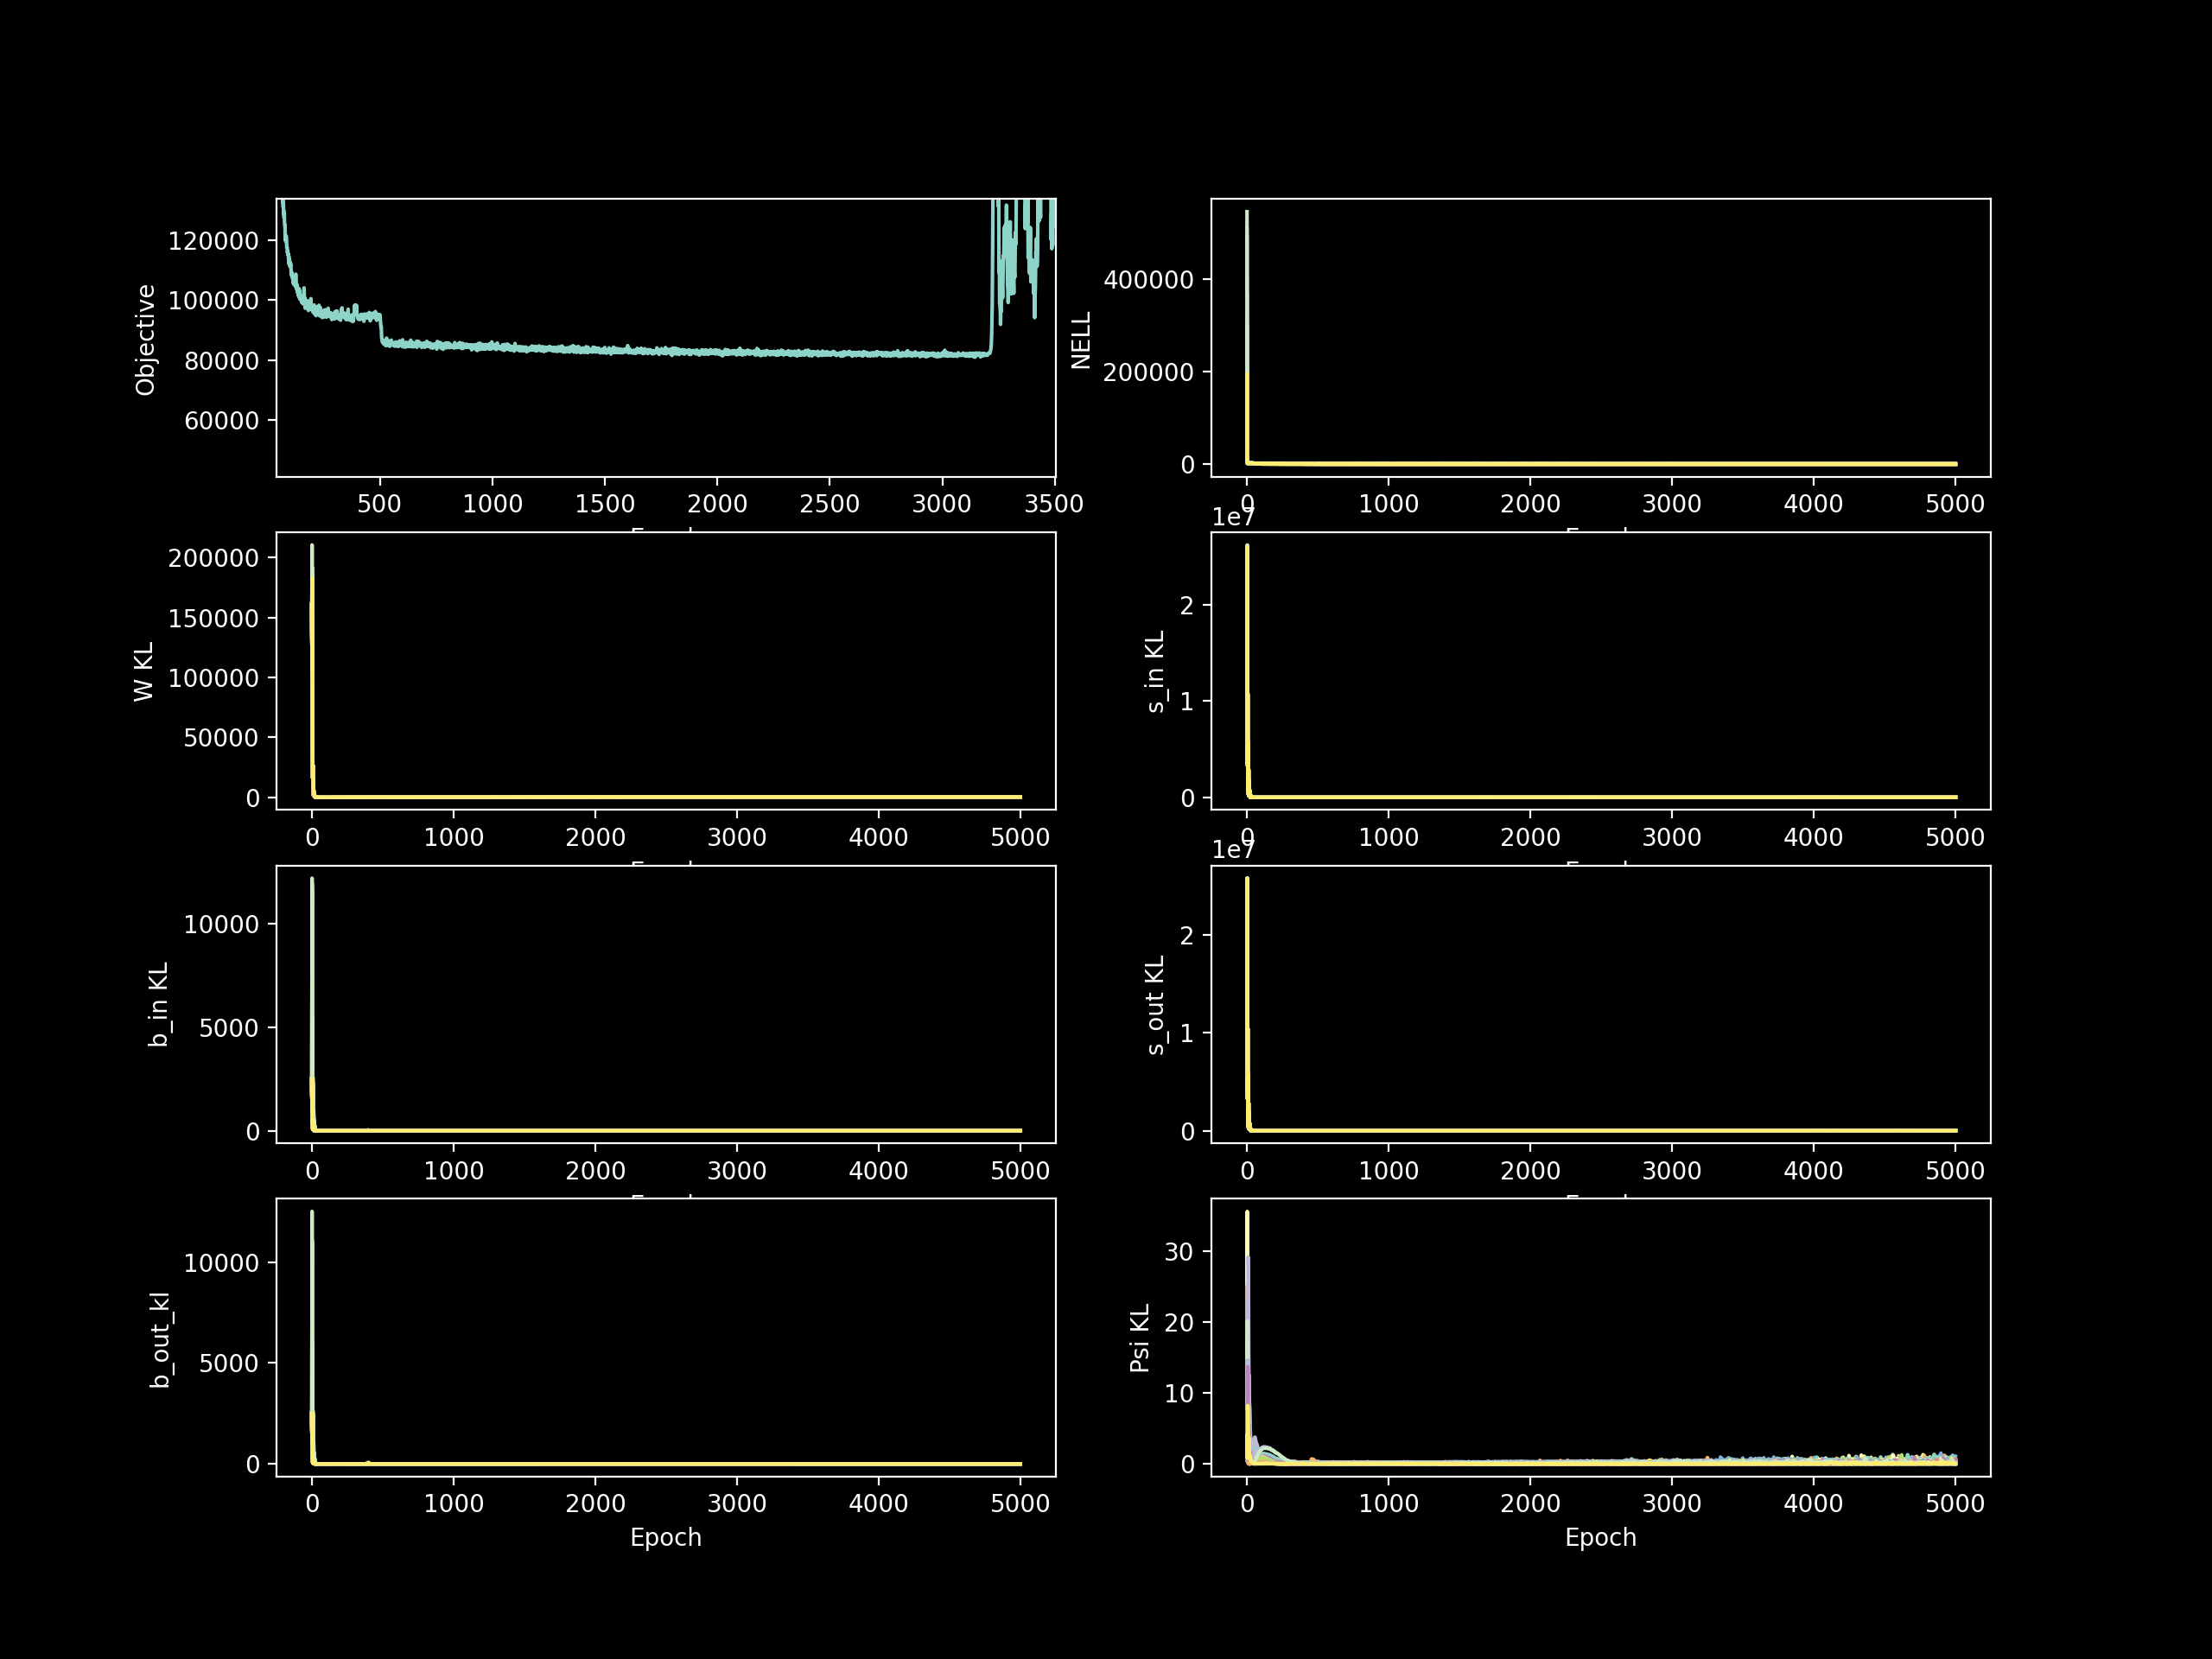

In [18]:
for log in exam_logs:
    Fitter.plot_log(log)

<IPython.core.display.Javascript object>


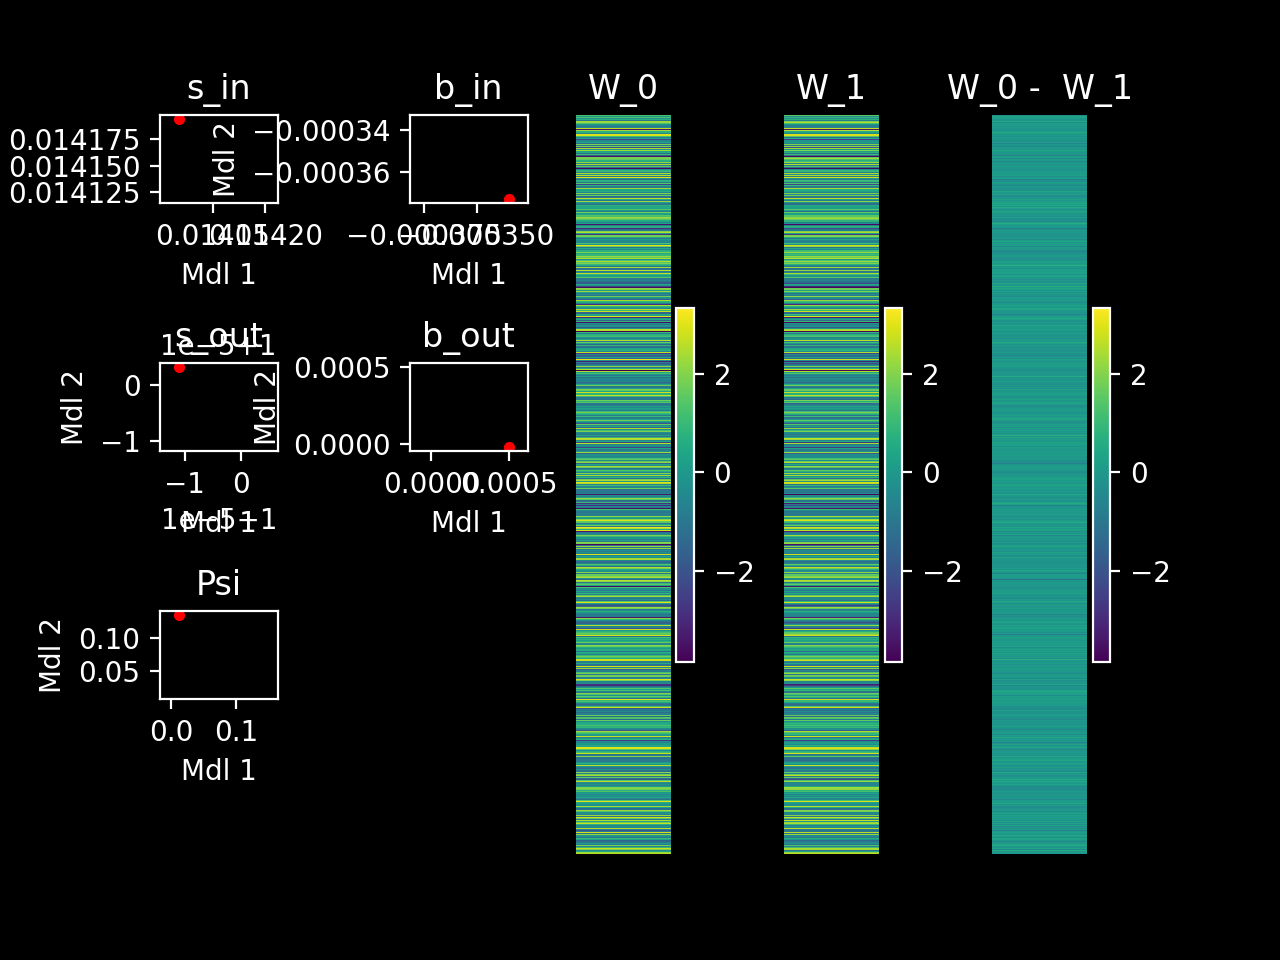

[[-1.0055357]]


In [39]:
exam_w = exam_posts[exam_ind].w_post(ind_props[exam_ind])
exam_s_in = exam_posts[exam_ind].s_in_post(ind_props[exam_ind]).squeeze(axis=1)
exam_b_in = exam_posts[exam_ind].b_in_post(ind_props[exam_ind]).squeeze(axis=1)
exam_s_out = exam_posts[exam_ind].s_out_post(ind_props[exam_ind]).squeeze(axis=1)
exam_b_out = exam_posts[exam_ind].b_out_post(ind_props[exam_ind]).squeeze(axis=1)
exam_psi = exam_posts[exam_ind].psi_post.dists[0].mode(ind_props[exam_ind]).squeeze(axis=1)

exam_mdl = GNLRMdl(m = exam_vi_collections[exam_ind].mdl.m, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                  s_out=exam_s_out, b_out=exam_b_out, psi=exam_psi)

plt.figure()
GNLRMdl.compare_mdls(ind_true_mdls[exam_ind], exam_mdl)

## Look at predicted mean values over the full range of input values for the exam_ind individual

In [20]:
n_exam_smps = 1000

In [21]:
x_exam = torch.tensor(sample_proj_data_from_interval(n_smps=n_exam_smps, 
                                                      w=ind_true_mdls[exam_ind].w.detach().numpy(), 
                                                      interval=interval),
                       dtype=torch.float)
#x_exam = ind_data[exam_ind][0]
n_exam_smps = x_exam.shape[0]

In [22]:
with torch.no_grad():
    
    # Determine which of our test points are in and out of the training distribution for this individual 
    x_true_proj = ind_true_mdls[exam_ind].project(x_exam).numpy()
    x_true_proj_for_int = ind_true_mdls[exam_ind].project(x_exam, apply_scales_and_biases=False).numpy().squeeze()
    
    x_within_train_dist = np.logical_and(x_true_proj_for_int >= interval[0], 
                                         x_true_proj_for_int < interval[1])
    x_outside_train_dist = np.logical_not(x_within_train_dist)
    
    # Get true mean and predicted mean for each data point for this individual 
    true_mns = ind_true_mdls[exam_ind].m(ind_true_mdls[exam_ind].project(x_exam)).numpy()
    pred_mns = exam_mdls[exam_ind].cond_mean(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                                             s_out=exam_s_out, b_out=exam_b_out)
    x_pred_proj = exam_mdls[exam_ind].project(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in)


### Look at point-by-point correspondance

<IPython.core.display.Javascript object>


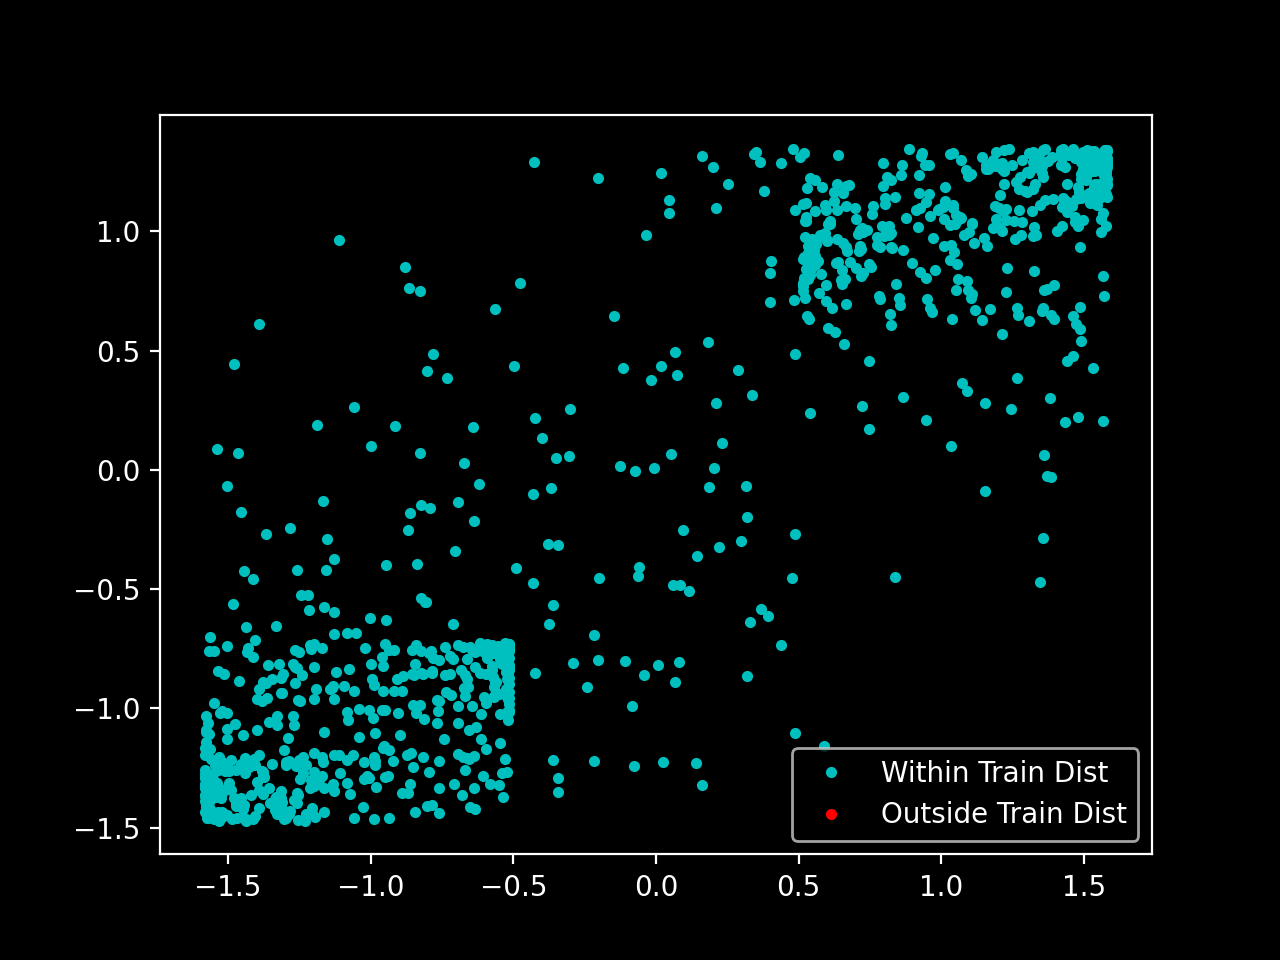

In [40]:
plt.figure()
plt.plot(true_mns[x_within_train_dist], pred_mns[x_within_train_dist], 'c.')
plt.plot(true_mns[x_outside_train_dist], pred_mns[x_outside_train_dist], 'r.')
plt.legend(['Within Train Dist', 'Outside Train Dist'])


## Look at correspondance of the m functions

### Look at shape of surface of true and predict means as a function of the true low-d projections

<IPython.core.display.Javascript object>


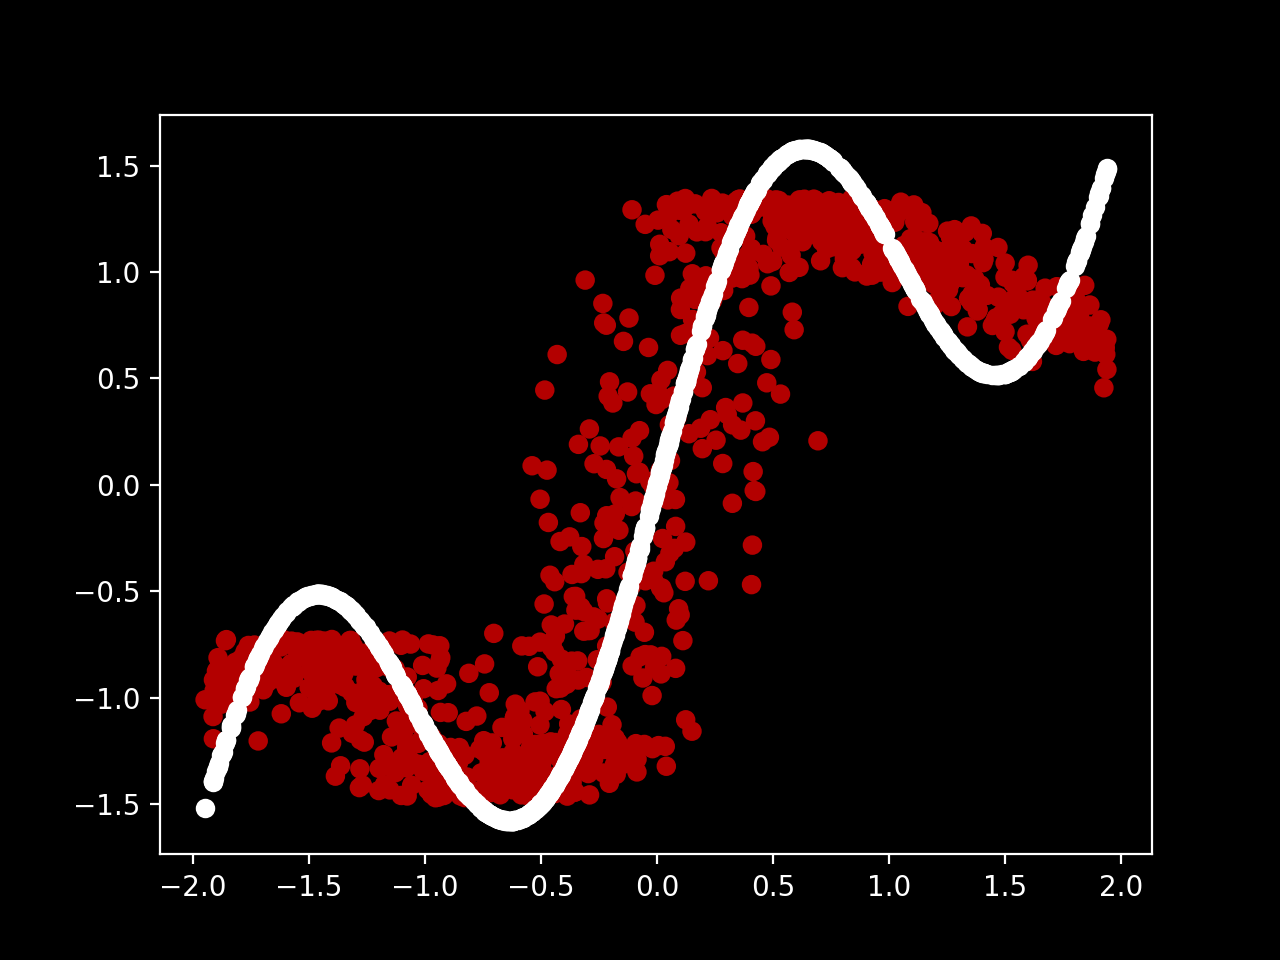

In [41]:
true_clrs = np.zeros([n_exam_smps,4])
true_clrs[:,-1] = 1.0
true_clrs[x_outside_train_dist, 0] = 1.0

pred_clrs = np.zeros([n_exam_smps,4])
pred_clrs[:, -1] = 1.0
pred_clrs[x_outside_train_dist, 0:3] = .5
#pred_clrs[x_outside_train_dist, -1] = 0 
pred_clrs[np.logical_not(x_outside_train_dist), 0] = .7


plt.figure()
a = plt.subplot(1,1,1)
a.scatter(x_true_proj, pred_mns, color=pred_clrs)
a.scatter(x_true_proj, true_mns, color='w')





### Look at shape of surface of true and predicted means when predicted means are also a function of the predicted low-d projections.

This is a more stringent test of identifiability than the above plots, becuase the learned models could "scramble" the projection to the low-s space and then the learned m-module could sort it out so that mean predictions when viewed as a function from input variables to means is correct, even though the intermediate transformation to low-d variables, and therefore the mapping from low-d variables to means, is not the same as the true models

In [42]:
# Get the estimate low-d projections in the space best aligned to truth

align_vls = align_low_d_spaces(w_0=ind_true_mdls[exam_ind].w.detach().numpy(),
                               s_in_0=ind_true_mdls[exam_ind].s_in.detach().numpy(),
                               b_in_0=ind_true_mdls[exam_ind].b_in.detach().numpy(),
                               w_1=exam_w.detach().numpy(),
                               s_in_1=exam_s_in.detach().numpy(),
                               b_in_1=exam_b_in.detach().numpy(),
                               z_1=x_pred_proj.numpy())

x_pred_proj_aligned = align_vls[-1]

<IPython.core.display.Javascript object>


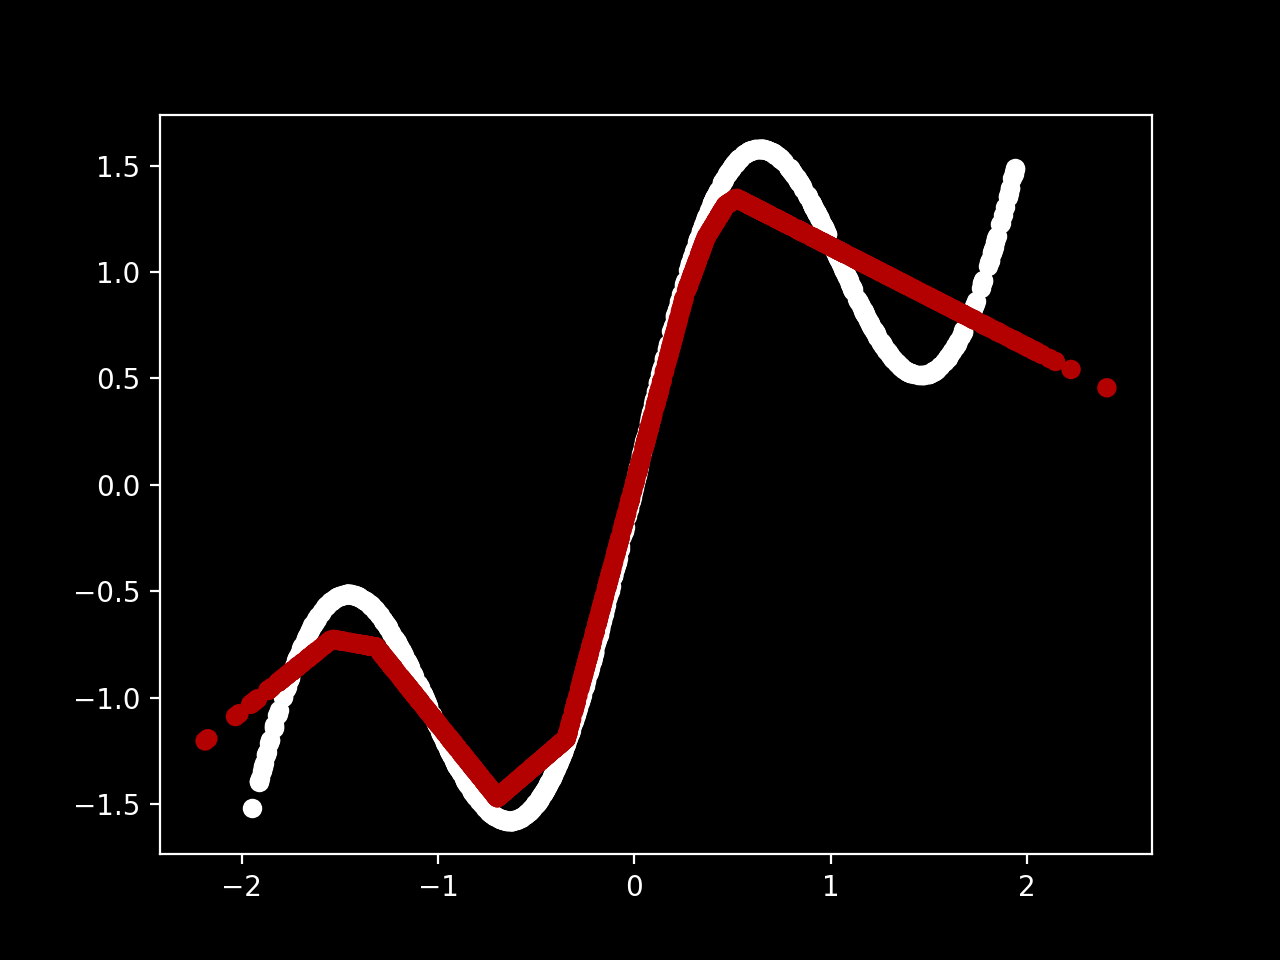

In [43]:
# Generate plots
plt.figure()
a = plt.subplot(1,1,1)
a.scatter(x_true_proj, true_mns, color='w')
a.scatter(x_pred_proj_aligned, pred_mns, color=pred_clrs)


## Compare true and fit prior distributions over weights

<IPython.core.display.Javascript object>


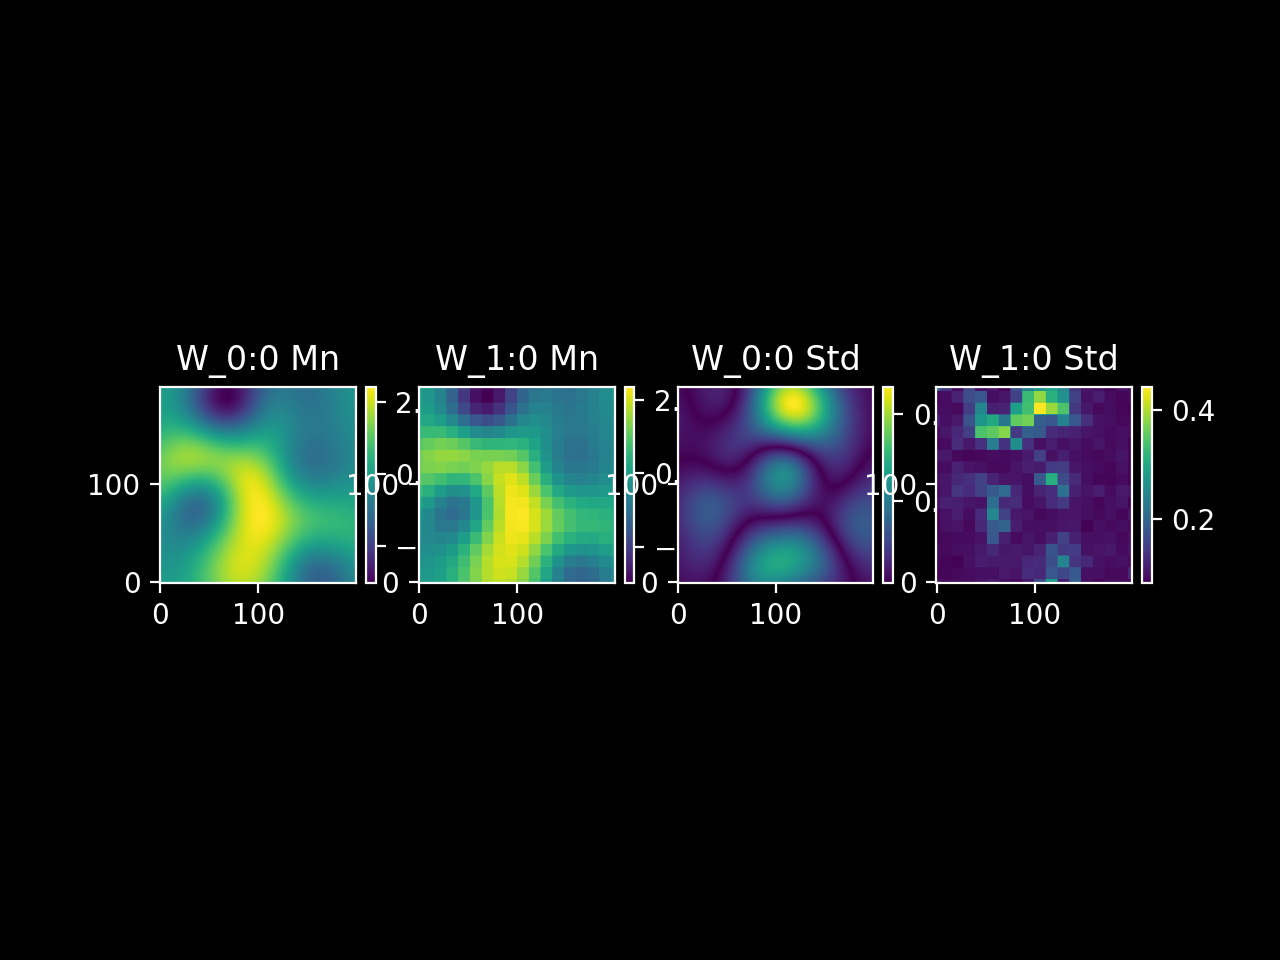

In [44]:
compare_weight_prior_dists(w0_prior=true_priors.w_prior, w1_prior=exam_priors.w_prior, 
                           dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[200, 200])

## Debug code

In [28]:
import matplotlib.cm as cm

In [29]:
len(exam_posts)

80

In [30]:
w_post_mns = [exam_posts[i].w_post(props).detach().numpy() for i, props in enumerate(ind_props)]
w_post_stds = [exam_posts[i].w_post.dists[0].std_f(props).detach().numpy() for i, props in enumerate(ind_props)]

w_prior_mns = [exam_priors.w_prior(props).detach().numpy() for i, props in enumerate(ind_props)]
w_prior_stds = [exam_priors.w_prior.dists[0].std_f(props).detach().numpy() for i, props in enumerate(ind_props)]

true_w_vls = [mdl.w.detach().numpy() for mdl in ind_true_mdls]

ind_props_np = [props.numpy() for props in ind_props]

In [31]:
w_mn_diffs = [v0 - v1 for v0, v1 in zip(w_post_mns, w_prior_mns)]

#### Look at posterior means

In [32]:
c_range = [-4, 1]

In [33]:
w_clrs = [cm.viridis((v-c_range[0])/(c_range[1] - c_range[0])) for v in w_post_mns]

<IPython.core.display.Javascript object>


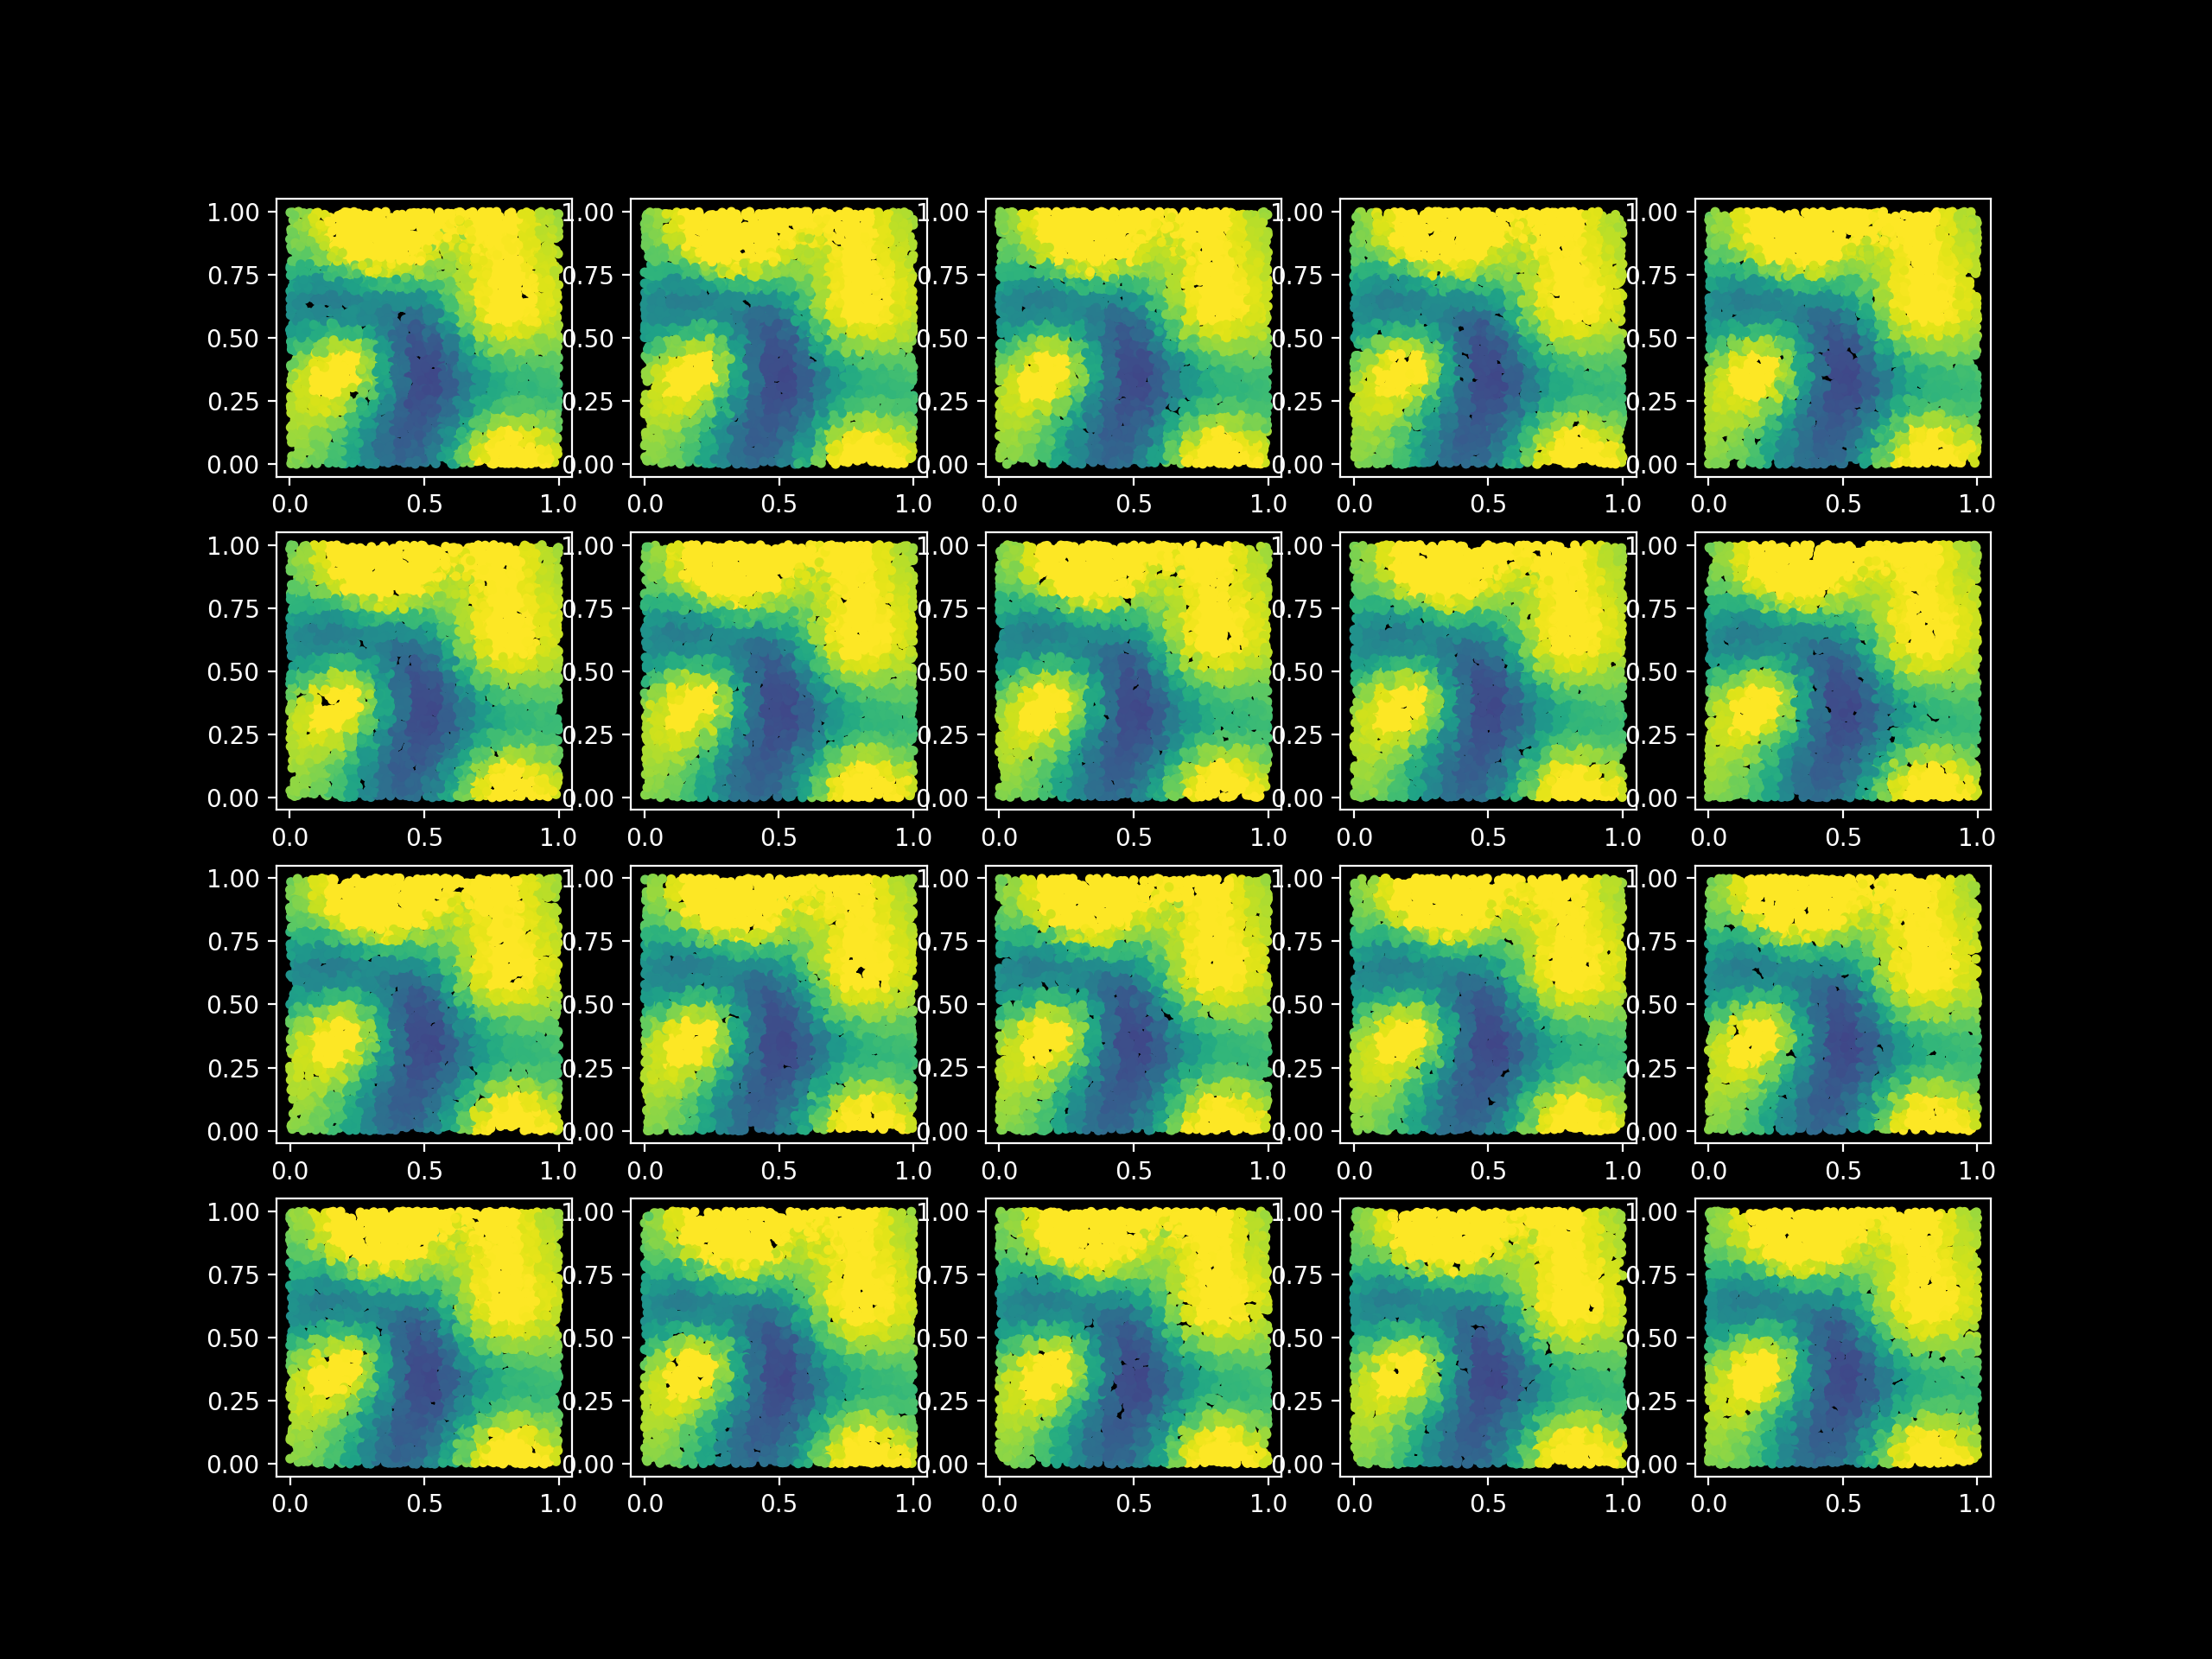

In [34]:
plt.figure()
for i in range(20):
    ax = plt.subplot(4,5,i+1)
    plt.scatter(ind_props[i][:,1], ind_props[i][:,0], color=w_clrs[i], marker='.')

In [35]:
def grid_stats(vls: np.ndarray, coords: np.ndarray, d0_range, d1_range):
    
    d0_bins = np.arange(*d0_range)
    d1_bins = np.arange(*d0_range)
    
    n_d0_bins = len(d0_bins) - 1
    n_d1_bins = len(d1_bins) - 1
    
    mn_vls = np.zeros([n_d0_bins, n_d1_bins])
    std_vls = np.zeros([n_d0_bins, n_d1_bins])
    
    for i0 in range(n_d0_bins):
        d0_pts = np.logical_and(coords[:,0] >= d0_bins[i0], coords[:,0] < d0_bins[i0+1])
        for i1 in range(n_d1_bins):
            d1_pts = np.logical_and(coords[:,1] >= d1_bins[i1], coords[:,1] < d1_bins[i1+1])
            
            bin_pts = np.logical_and(d0_pts, d1_pts)
            
            mn_vls[i0, i1] = np.mean(vls[bin_pts])
            std_vls[i0, i1] = np.std(vls[bin_pts])
            
    d0_coords = (d0_bins[0:-1] - d0_bins[1:])/2
    d1_coords = (d1_bins[0:-1] - d1_bins[1:])/2
            
    return mn_vls, std_vls, d0_coords, d1_coords

In [36]:
mn_im, std_im, _, _ = grid_stats(vls=np.concatenate(w_post_mns, axis=0), 
                                 coords=np.concatenate(ind_props_np, axis=0),
                                 d0_range = (0, 1, .05), 
                                 d1_range = (0, 1, .05))

<IPython.core.display.Javascript object>


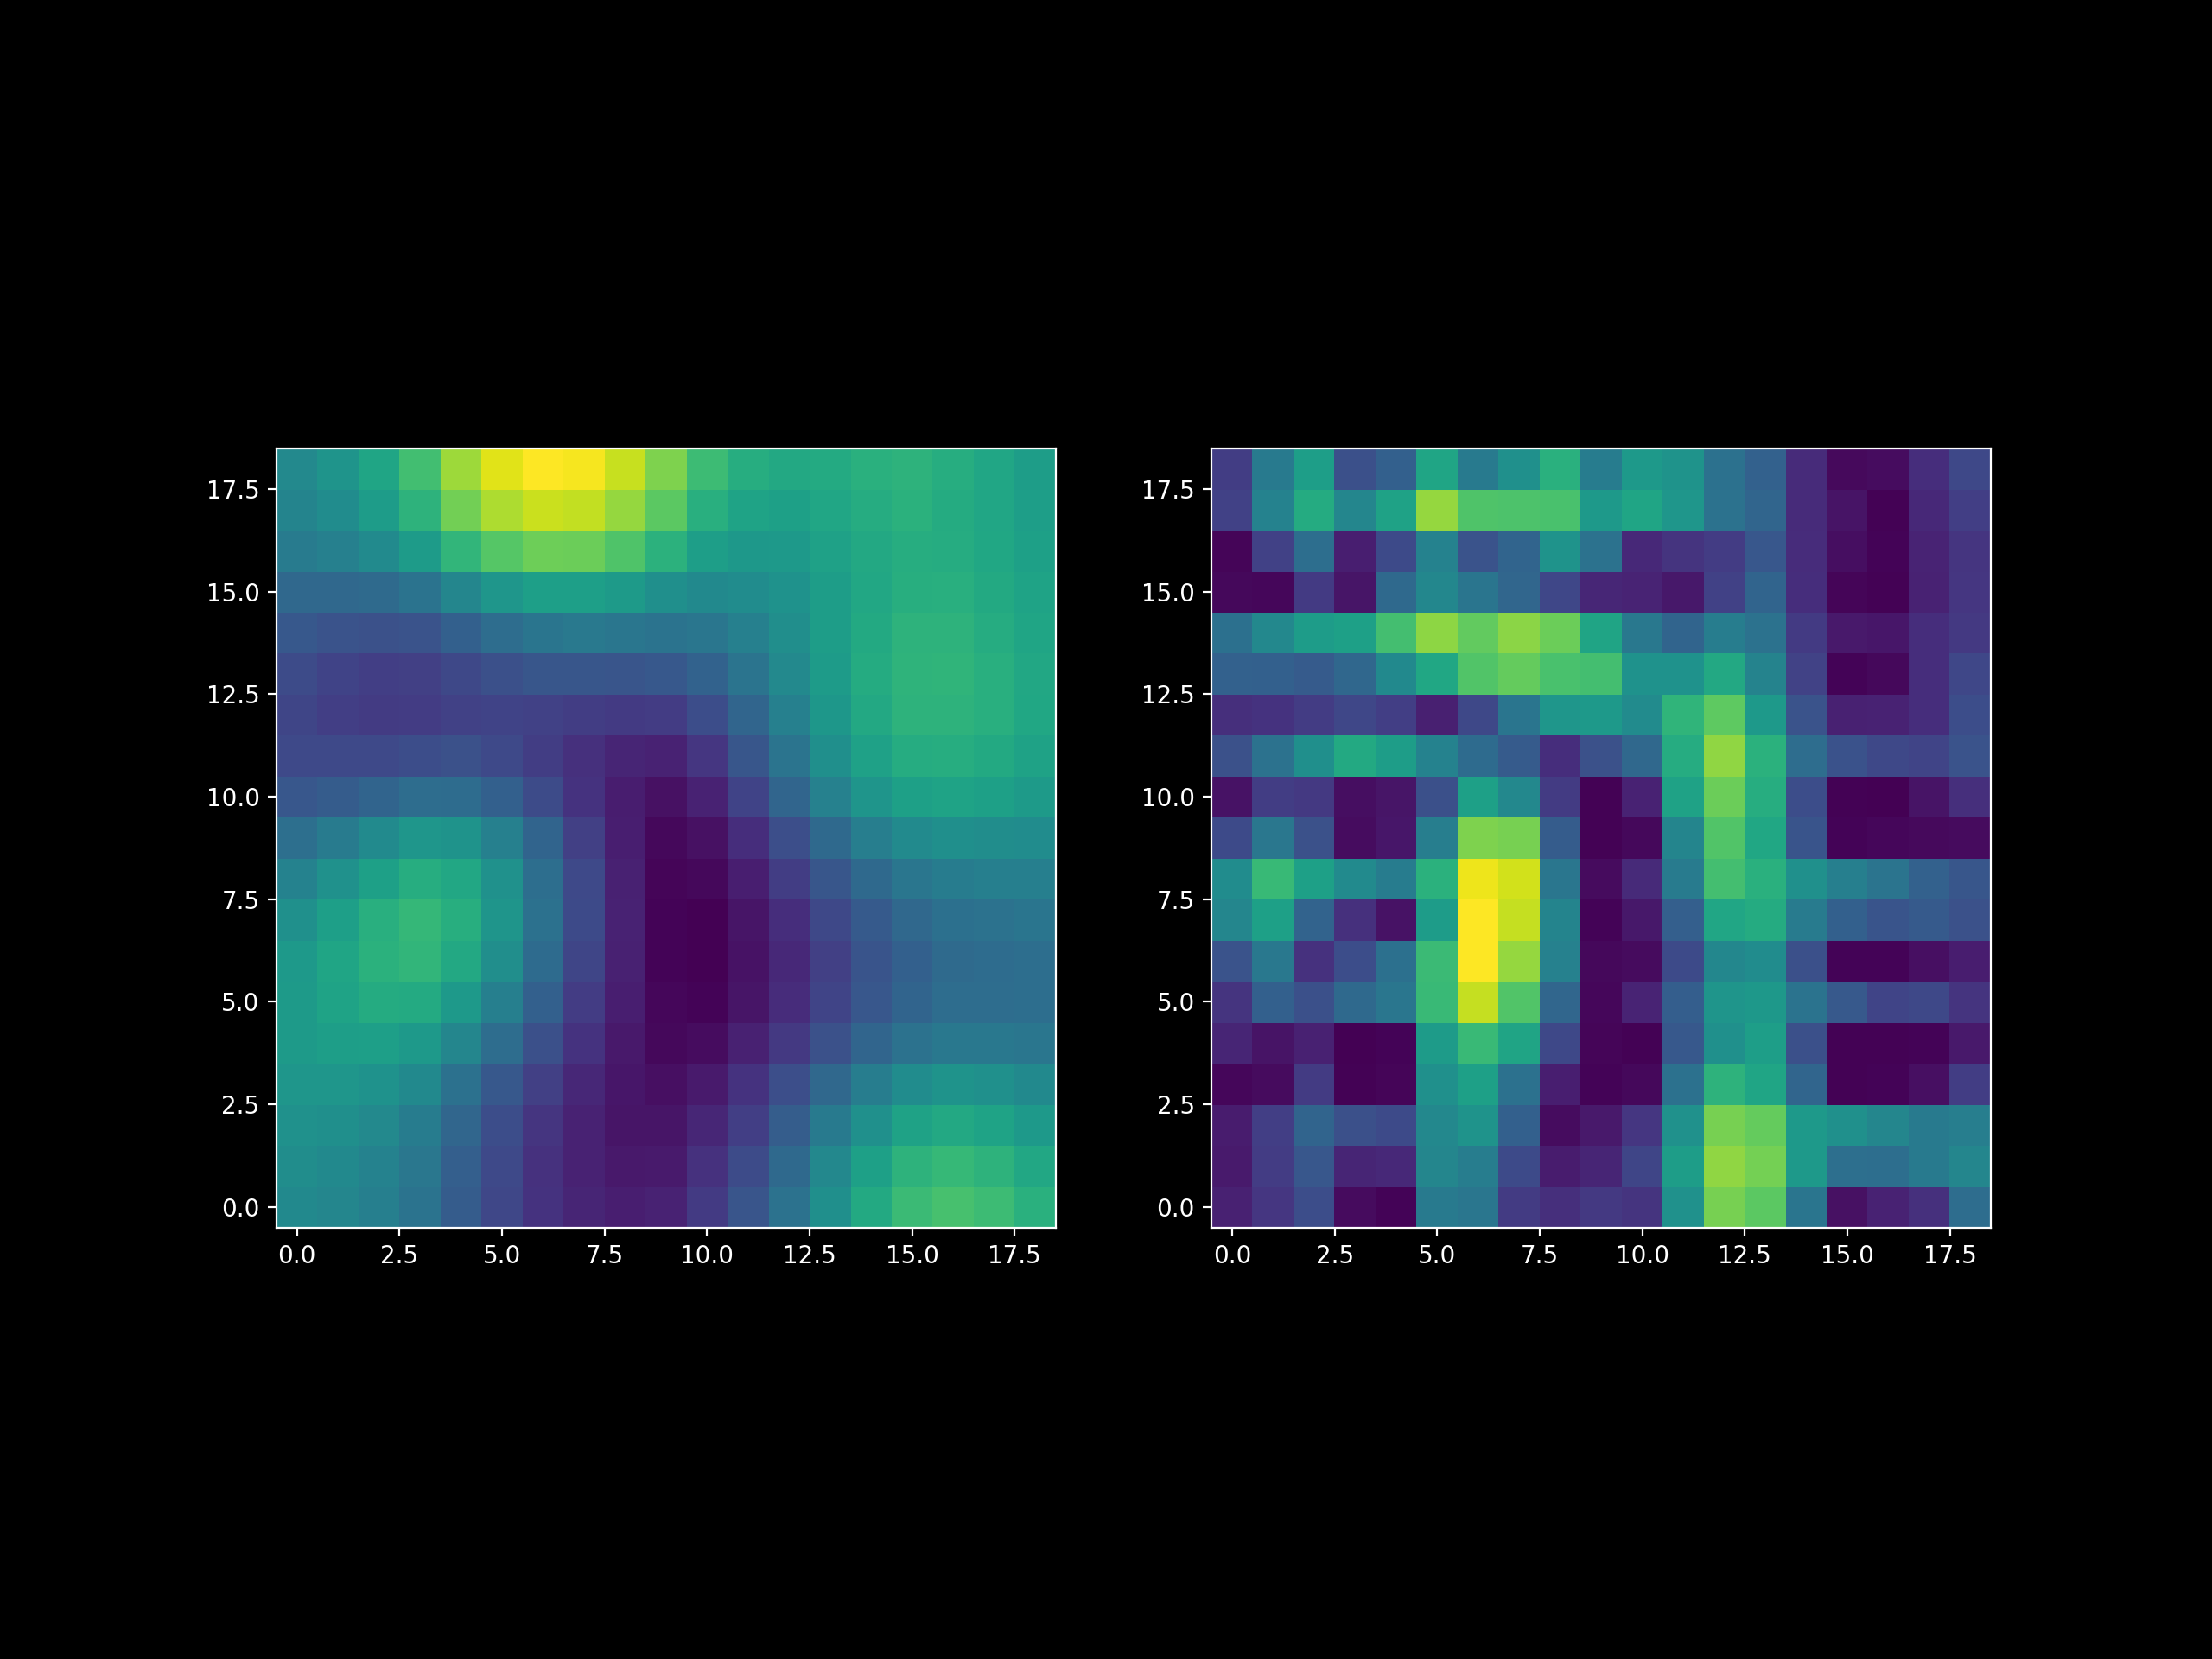

In [37]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mn_im, origin='lower')
plt.subplot(1,2,2)
plt.imshow(std_im, origin='lower')